# simple model emulators of each ESM

Can we emulate land carbon sink?

Use a box model framework and fit the parameters to each ESM

fit using ZEC, test using CDR


### Box Model
$NPP = NBP + RH$ 

$\frac{d M_V}{dt} = NPP - fV \cdot M_V$

$\frac{d M_L}{dt} =fV \cdot M_V - f_L \cdot M_L - (1-f_L) \cdot M_L \cdot Q_{10}^{T/10}$

$\frac{d M_S}{dt} = f_L \cdot M_L - fS \cdot M_S \cdot Q_{10}^{T/10}$

$RH = (1-f_L) \cdot M_L \cdot Q_{10}^{T/10} + fS \cdot M_S \cdot Q_{10}^{T/10}$


#### Input fields
$nbp$  
$rh$  
$T$

#### Unknown constants
$f_V$  
$f_L$  
$f_S$  
$Q_{10}$

$\tau = 1/f$

#### Optimize against model output 
$M_V$  
$M_L$  
$M_S$
$RH$

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
from xarray.coding.times import CFTimedeltaCoder

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True

import glob

## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

from scipy.optimize import minimize


from loading_function_flat10 import load_flat10, load_one_model, load_one_model_onevar, load_grid, select_time_slice, weighted_temporal_mean 


In [2]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

In [3]:
def get_full_ts_flat10(modelname, exp, var, latrange):

    '''
    inputs (modelname, exp, var, latrange)
    outputs (VAR_ts) 
    
    # unit conversions need to be made after this is called
    # GPP_ts= GPP *  speryr #convert from Pg/s to Pg/yr
    # T_tszec = T-273.15
    # RH_tszec= RH *  speryr #convert from Pg/s to Pg/yr
    # NBP_tszec= NBP *  speryr #convert from Pg/s to Pg/yr
    
    '''
    timeseriesE=ds_C_global.sel(model=modelname, run='flat10', 
                                   var=var, latrange=latrange)
    
    timeseries=ds_C_global.sel(model=modelname, run=exp, 
                                   var=var, latrange=latrange)
    
    VAR_ts=np.append(timeseriesE.data[0:100].values, timeseries.data[0:200].values) 
    
    return VAR_ts


## Load data and metadata

In [4]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh','tas','pr'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
#varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']
### from ben: colors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]


latlist=['global','highlat','troplat','midlat']

markerlist=['o','v','^','<','>','s','*','P','d','X']



In [5]:
# load timeseries of data
ds_C_global = xr.open_dataset("C_metrics_matrix_S.nc")

In [6]:
ds_C_global


<xarray.Dataset> Size: 3MB
Dimensions:   (time: 350, model: 9, run: 3, var: 9, latrange: 4)
Coordinates:
  * time      (time) int64 3kB 0 1 2 3 4 5 6 7 ... 343 344 345 346 347 348 349
  * model     (model) <U13 468B 'ACCESS-ESM1-5' 'CESM2' ... 'UKESM1.2'
  * run       (run) <U10 120B 'flat10' 'flat10_zec' 'flat10_cdr'
  * var       (var) <U7 252B 'cVeg' 'cSoil' 'cLitter' ... 'tas' 'pr' 'cTot'
  * latrange  (latrange) <U7 112B 'global' 'highlat' 'troplat' 'midlat'
Data variables:
    data      (time, model, run, var, latrange) float64 3MB ...

## 3 box model, solve for fV, fL, fS, Q10

In [7]:
## - this is the box model!

# 3 Box model, constant Q10, use fraction instead of tau

# Simulation function
def simulate_model_3box_cnstQ10_f(f_params):
    fV, fL, fS, Q10 = f_params
    if fV <= 0 or fL <= 0 or fS <= 0 or Q10 <= 0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    ML = np.zeros(n)
    MS = np.zeros(n)
    RH = np.zeros(n)

    MV[0], ML[0], MS[0] = MV0, ML0, MS0

    for y in range(1, n):
        ML[y-1] = max(ML[y-1], 1e-6)
        MS[y-1] = max(MS[y-1], 1e-6)
        
        if np.isnan(ML[y-1]) or np.isnan(MS[y-1]) or np.isnan(T[y]) or T[y] == 0:
            print(f"Invalid Q10 input at step {y}: T={T[y]}, ML[y-1]={ML[y-1]}, MS[y-1]={MS[y-1]},fL={fL},fS={fS}")
            return None
        RH = ((1-fL) * ML[y-1] + (fS * MS[y-1]))*np.exp((T[y]/10)*np.log(Q10))

        MV[y] = MV[y-1] + dt * (NPP[y] - fV*MV[y-1])
        ML[y] = ML[y-1] + dt * (
            fV*MV[y-1] - fL*ML[y-1] - (1 - fL) * ML[y-1] * Q10**(T[y]/10)
        )
        MS[y] = MS[y-1] + dt * (
            fL*ML[y-1] - fS * MS[y-1] * Q10**(T[y]/10)
        )

    return MV, ML, MS, RH

# Objective function
def objective_3box_cnstQ10_f(f_params):
    result = simulate_model_3box_cnstQ10_f(f_params)
    if result is None:
        return np.inf
    MV, ML, MS, RH = result
    # Mean squared error across all three time series
    # loss = (
    #     np.mean((MV - MV_obs) ** 2) +
    #     np.mean((ML - ML_obs) ** 2) +
    #     np.mean((MS - MS_obs) ** 2)
    # )

    loss = (
    np.mean((MV - MV_obs)**2) * 1.0 +
    np.mean((ML - ML_obs)**2) * 1.0 +  # Increase weight
    np.mean((MS - MS_obs)**2) * 2.0 +
    np.mean((RH-RH_obs)**2) * 1.0
    )
    return loss

## 2 box model 

In [19]:
## - this is the box model!

# 2 Box model, constant Q10, use fraction instead of tau

# Simulation function
def simulate_model_2box_cnstQ10_f(f_params):
    fV, fS, Q10 = f_params
    if fV <= 0 or fS <= 0 or Q10 <= 0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    MS = np.zeros(n)
    RH = np.zeros(n)

    MV[0], MS[0] = MV0, MS0

    for y in range(1, n):
        MS[y-1] = max(MS[y-1], 1e-6)
        
        if np.isnan(np.isnan(MS[y-1]) or np.isnan(T[y]) or T[y] == 0):
            print(f"Invalid Q10 input at step {y}: T={T[y]}, MS[y-1]={MS[y-1]},fS={fS}")
            return None
        RH = ((fS * MS[y-1]))*np.exp((T[y]/10)*np.log(Q10))

        MV[y] = MV[y-1] + dt * (NPP[y] - fV*MV[y-1])
        MS[y] = MS[y-1] + dt *  - fS * MS[y-1] * Q10**(T[y]/10)

    return MV, MS, RH

# Objective function
def objective_2box_cnstQ10_f(f_params):
    result = simulate_model_2box_cnstQ10_f(f_params)
    if result is None:
        return np.inf
    MV, MS, RH = result
    # Mean squared error across all three time series
    # loss = (
    #     np.mean((MV - MV_obs) ** 2) +
    #     np.mean((ML - ML_obs) ** 2) +
    #     np.mean((MS - MS_obs) ** 2)
    # )

    loss = (
    np.mean((MV - MV_obs)**2) * 1.0 +
    np.mean((MS - MS_obs)**2) * 2.0 +
    np.mean((RH-RH_obs)**2) * 1.0
    )
    return loss

## function to run box model and output parameters

In [20]:
# for some reason the box model can't find the data when run in a function...


def run_boxmodel(modellist, latrange, experiment):
    '''
    Code to run the box model for all models in modellist 
    for a specific latrange
    and a specific experiment

    latrange options: 'global','highlat','troplat','midlat'
    experiment options: 'flat10_zec' or 'flat10_cdr'
    
    '''
    
    dt=1 # timestep is 1 year
    Tb= 298.15 # base temperature (default is 25C)
    
    # initialize some empty arrays to store outputs
    fV_vec=np.empty(len(modellist))
    fL_vec=np.empty(len(modellist))
    fS_vec=np.empty(len(modellist))
    Q10_vec=np.empty(len(modellist))
    
    for m in range(len(modellist)):
        model=modellist[m]
        # mcolor=modelcolors[m]
        print ('estimating parameters for model: ' +model +' ' +experiment)
    
        # assign data from output
    
        #--- cLitter
        cLitter= get_full_ts_flat10(model, experiment, 'cLitter', latrange)
        ML_obs= cLitter
        ML0=ML_obs[0] #specify initial condition
              
        #--- TAS    
        To= get_full_ts_flat10(model, experiment, 'tas', latrange)
        T = To-Tb #remove baseline temp
        
        #--- RH
        RHo= get_full_ts_flat10(model, experiment, 'rh', latrange)
        RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr
        
        #--- NBP
        NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
        NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
        
        #--- cVeg  
        cVeg= get_full_ts_flat10(model, experiment, 'cVeg', latrange)
        MV_obs= cVeg 
        MV0=MV_obs[0]
        
        #--- cSoil
        cSoil= get_full_ts_flat10(model, experiment, 'cSoil', latrange)
        MS_obs= cSoil 
        MS0=MS_obs[0] # specify initial condition
    
        
        # calculate NPP from nbp and rh 
        NPP = NBP + RH_obs
    
        # select either 3 box model or 2 box model, depending on if litter output exists
        if np.isnan(ML_obs).any():
            print('no litter, using 2-Box model for: ' +model)
            # Initial guess and bounds
            initial_guess = [0.5,0.5, 1]#first guess for [fV,fS,Q10]
            bounds = [(1e-3, 1),  (1e-3, 1), (1e-3,3)]
            
            # Run optimization
            result = minimize(objective_2box_cnstQ10_f, x0=initial_guess, bounds=bounds)
            fV_opt, fS_opt, Q10_opt = result.x
            print("Optimization Result:", result)
            
            # Simulate with optimal parameters
            MV_best, MS_best, RH_best = simulate_model_2box_cnstQ10_f(result.x)
            
            # Plot results
            plt.figure(figsize=(12, 6))
            plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
            plt.plot(MV_best, label=f'Modeled MV',color='green')
            plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
            plt.plot(MS_best, label='Modeled MS',color='brown')
            plt.legend()
            plt.title(model +f' Optimized Parameters 2-Box: tauV={(1/fV_opt):.2f}, tauS={(1/fS_opt):.2f}, Q10={Q10_opt:.2f}')
            plt.show()
        
            fV_vec[m]=fV_opt
            fL_vec[m]=np.nan
            fS_vec[m]=fS_opt
            Q10_vec[m]=Q10_opt
    
        else: # use 3 box model
            print('using 3-Box model for: ' +model)
            # Initial guess and bounds
            initial_guess = [0.5, 0.5, 0.5, 1] # first guess for [fV,fL,fS,Q10]
            bounds = [(1e-3, 1), (1e-3, 1), (1e-3, 1), (1e-3,3)] #bounds for guesses
            
            # Run optimization
            result = minimize(objective_3box_cnstQ10_f, x0=initial_guess, bounds=bounds)
            fV_opt, fL_opt, fS_opt, Q10_opt = result.x
            print("Optimization Result:", result)
            
            # Simulate with optimal parameters
            MV_best, ML_best, MS_best, RH_best = simulate_model_3box_cnstQ10_f(result.x)
            
            # Plot results
            plt.figure(figsize=(12, 6))
            plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
            plt.plot(MV_best, label=f'Modeled MV',color='green')
            plt.plot(ML_obs, label='Observed ML',color='orange',linestyle='--')
            plt.plot(ML_best, label='Modeled ML',color='orange')
            plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
            plt.plot(MS_best, label='Modeled MS',color='brown')
            plt.legend()
            plt.title(model +f' Optimized Parameters 3-Box: tauV={(1/fV_opt):.2f}, tauL={(1/fL_opt):.2f}, tauS={(1/fS_opt):.2f}, Q10={Q10_opt:.2f}')
            plt.show()
        
            fV_vec[m]=fV_opt
            fL_vec[m]=fL_opt
            fS_vec[m]=fS_opt
            Q10_vec[m]=Q10_opt
        
    # #-- add output to a pandas data frame
    esm_boxfit = pd.DataFrame({})
    esm_boxfit['fV']=fV_vec
    esm_boxfit['fL']=fL_vec
    esm_boxfit['fS']=fS_vec
    esm_boxfit['Q10']=Q10_vec
    
    esm_boxfit.index=modellist

    return esm_boxfit #return a pandas dataframe with the parameter estimates
    


## Estimate parameters for the box model fit to ESM output

In [21]:
# modellist= ['ACCESS-ESM1-5',  
#             'CESM2',    
#             'GFDL-ESM4',  
#             'GISS_E2.1',  
#             'NorESM2-LM',
#             'MPI-ESM1-2-LR',
#             'CNRM-ESM2-1',
#             'HadCM3LC-Bris']#,
#             #'UKESM1.2'] # no NPB for UKESM


# latrange='global'

# esm_boxfit_global_zec=run_boxmodel(modellist, latrange, 'flat10_zec')


estimating parameters for model: ACCESS-ESM1-5
using 3-Box model for: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 338.98114709195397
        x: [ 6.663e-02  2.688e-01  2.263e-02  1.177e+00]
      nit: 67
      jac: [-1.223e+02  2.134e+01 -2.667e+02  1.392e+01]
     nfev: 565
     njev: 113
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


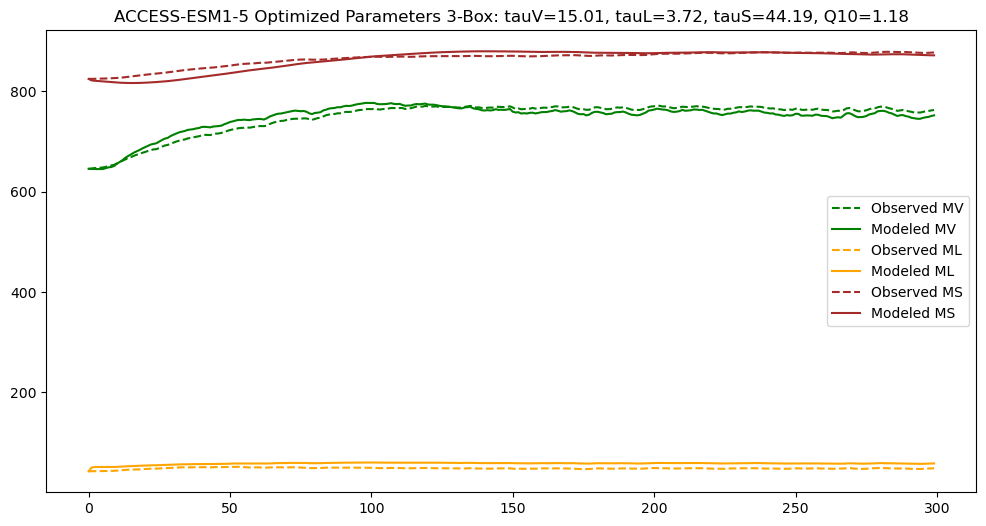

estimating parameters for model: CESM2
using 3-Box model for: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1159.7440408428827
        x: [ 6.412e-02  1.000e+00  1.537e-01  3.000e+00]
      nit: 33
      jac: [-1.555e-02 -1.918e+02 -5.912e-03 -4.732e+02]
     nfev: 250
     njev: 50
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


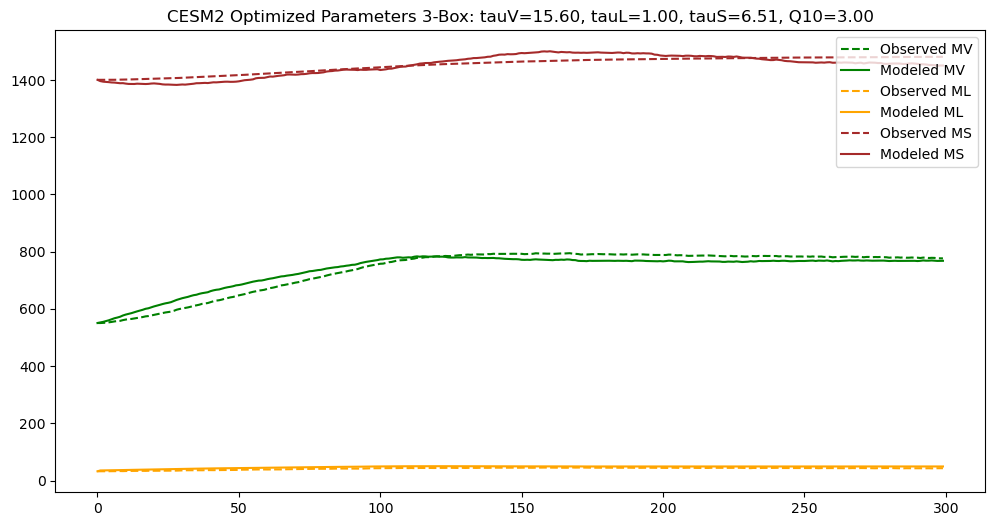

estimating parameters for model: GFDL-ESM4
using 3-Box model for: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2369.067047262125
        x: [ 1.046e-01  1.344e-03  5.444e-03  2.743e+00]
      nit: 54
      jac: [-8.376e-02 -1.215e+03  2.708e+02 -5.130e-01]
     nfev: 505
     njev: 101
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


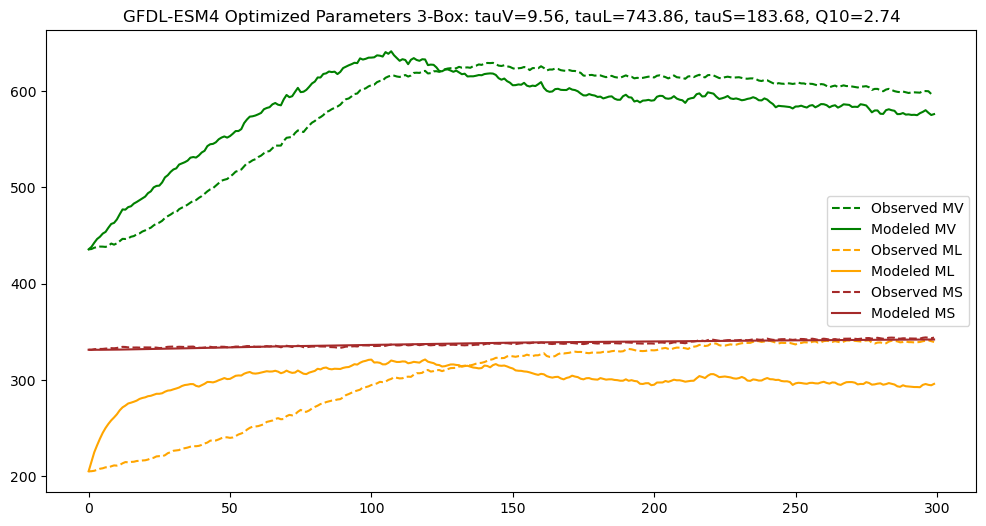

estimating parameters for model: GISS_E2.1
no litter, using 2-Box model for: GISS_E2.1
Optimization Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 15715.090286525834
        x: [ 6.328e-02  1.000e-03  3.000e+00]
      nit: 23
      jac: [ 0.000e+00  9.999e+06 -4.775e+03]
     nfev: 124
     njev: 31
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


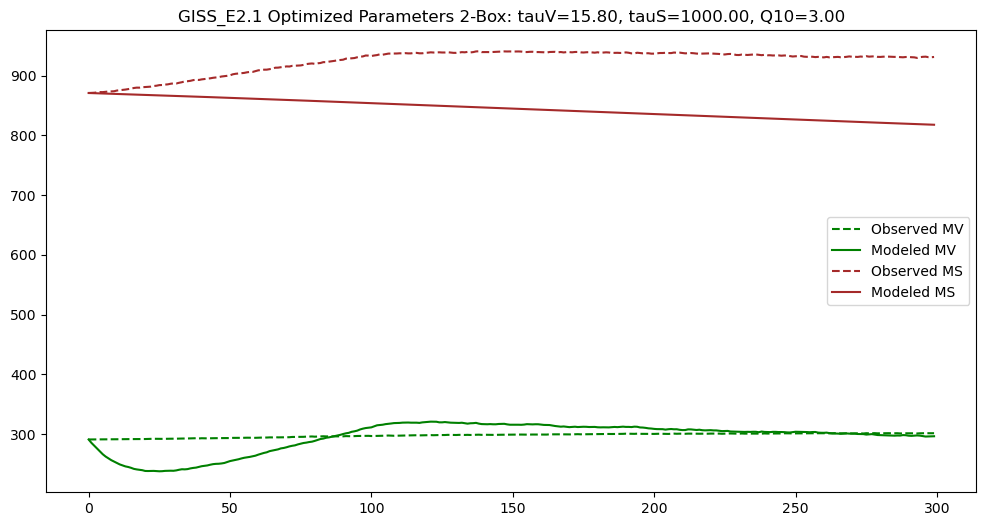

estimating parameters for model: NorESM2-LM
using 3-Box model for: NorESM2-LM
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 6172.136162138148
        x: [ 6.506e-02  7.212e-01  7.951e-02  3.000e+00]
      nit: 42
      jac: [-1.726e+01 -8.695e-01  3.121e+01 -2.860e+03]
     nfev: 265
     njev: 53
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


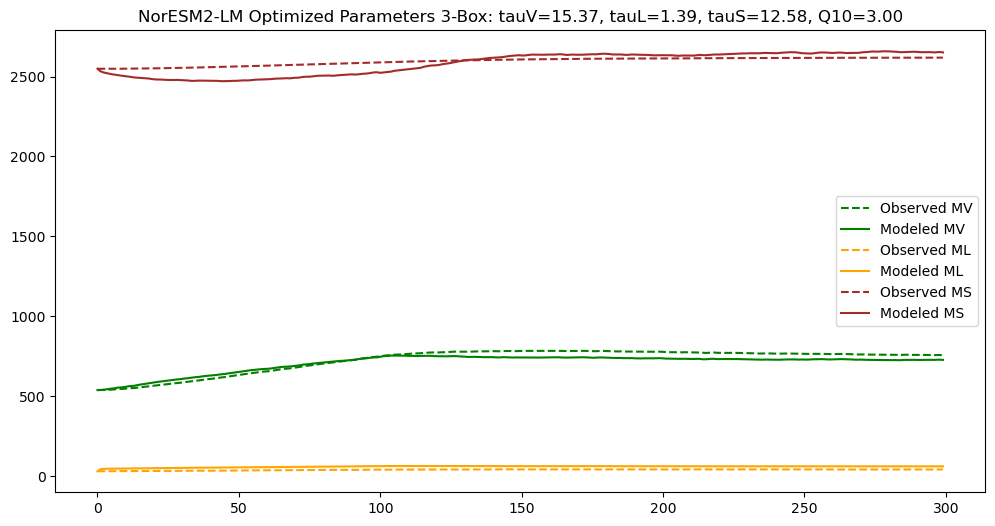

estimating parameters for model: MPI-ESM1-2-LR
using 3-Box model for: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1081.4254983591147
        x: [ 1.318e-01  2.505e-02  5.033e-02  2.710e+00]
      nit: 45
      jac: [-2.385e-02 -2.161e-01  1.085e-01 -4.957e-03]
     nfev: 415
     njev: 83
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


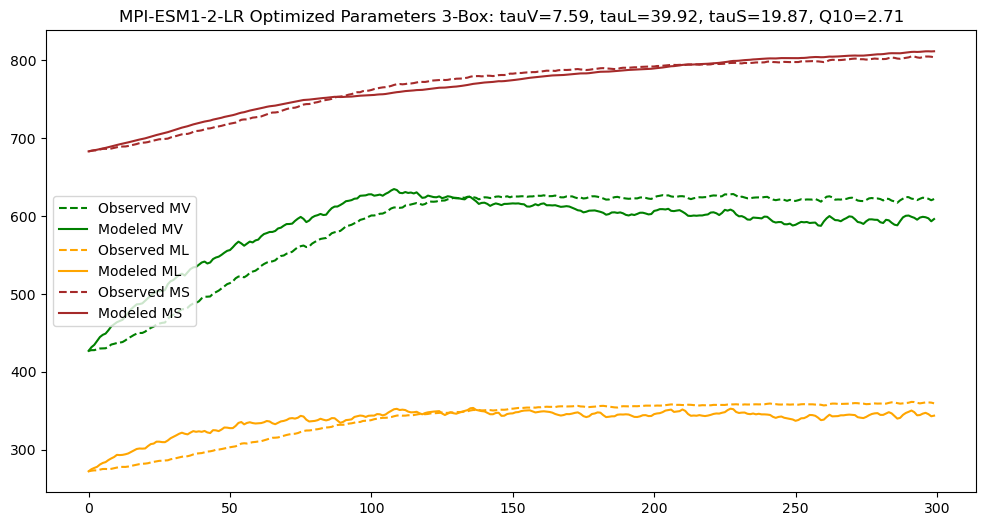

estimating parameters for model: CNRM-ESM2-1
using 3-Box model for: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3182.6496920579816
        x: [ 6.319e-02  3.666e-03  1.000e-03  3.000e+00]
      nit: 45
      jac: [ 2.691e+00  2.201e+01  2.304e+04 -8.193e+03]
     nfev: 415
     njev: 83
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


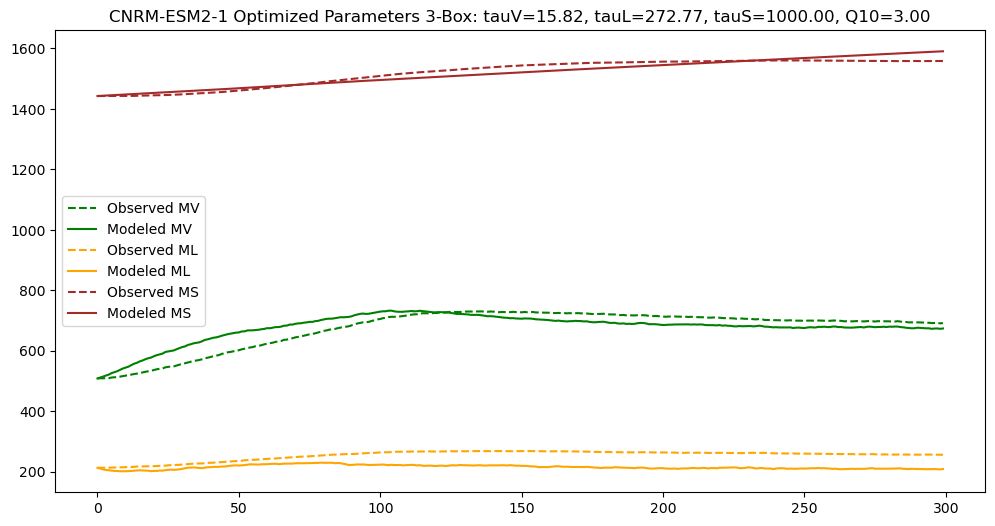

estimating parameters for model: HadCM3LC-Bris
no litter, using 2-Box model for: HadCM3LC-Bris
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 57462.45625295913
        x: [ 1.162e-01  1.000e-03  3.000e+00]
      nit: 8
      jac: [-8.731e-03  2.270e+07 -1.201e+04]
     nfev: 92
     njev: 23
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


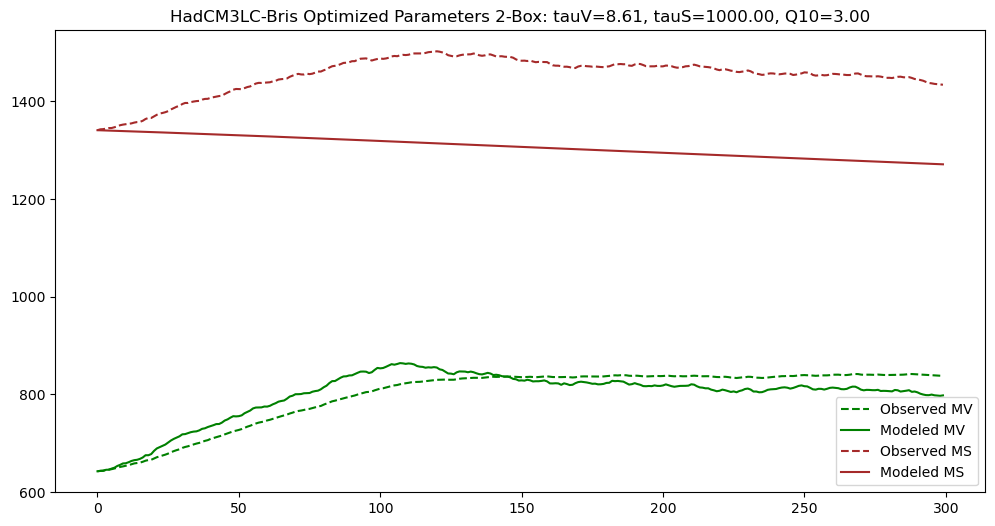

In [23]:
latrange='global'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year
Tb= 298.15 # base temperature (default is 25C)

# initialize some empty arrays to store outputs
fV_vec=np.empty(len(modellist))
fL_vec=np.empty(len(modellist))
fS_vec=np.empty(len(modellist))
Q10_vec=np.empty(len(modellist))

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output

    #--- cLitter
    cLitter= get_full_ts_flat10(model, experiment, 'cLitter', latrange)
    ML_obs= cLitter
    ML0=ML_obs[0] #specify initial condition
       
    #--- TAS    
    To= get_full_ts_flat10(model, experiment, 'tas', latrange)
    T = To-Tb #remove baseline temp
    
    #--- RH
    RHo= get_full_ts_flat10(model, experiment, 'rh', latrange)
    RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, experiment, 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]
    
    #--- cSoil
    cSoil= get_full_ts_flat10(model, experiment, 'cSoil', latrange)
    MS_obs= cSoil 
    MS0=MS_obs[0] # specify initial condition

    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH_obs


    # select either 3 box model or 2 box model, depending on if litter output exists
    if np.isnan(ML_obs).any():
        print('no litter, using 2-Box model for: ' +model)
        # Initial guess and bounds
        initial_guess = [0.5,0.5, 1]#first guess for [fV,fS,Q10]
        bounds = [(1e-3, 1),  (1e-3, 1), (1e-3,3)]
        
        # Run optimization
        result = minimize(objective_2box_cnstQ10_f, x0=initial_guess, bounds=bounds)
        fV_opt, fS_opt, Q10_opt = result.x
        print("Optimization Result:", result)
        
        # Simulate with optimal parameters
        MV_best, MS_best, RH_best = simulate_model_2box_cnstQ10_f(result.x)
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
        plt.plot(MV_best, label=f'Modeled MV',color='green')
        plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
        plt.plot(MS_best, label='Modeled MS',color='brown')
        plt.legend()
        plt.title(model +f' Optimized Parameters 2-Box: tauV={(1/fV_opt):.2f}, tauS={(1/fS_opt):.2f}, Q10={Q10_opt:.2f}')
        plt.show()
    
        fV_vec[m]=fV_opt
        fL_vec[m]=np.nan
        fS_vec[m]=fS_opt
        Q10_vec[m]=Q10_opt

    else: # use 3 box model
        print('using 3-Box model for: ' +model)
        # Initial guess and bounds
        initial_guess = [0.5, 0.5, 0.5, 1] # first guess for [fV,fL,fS,Q10]
        bounds = [(1e-3, 1), (1e-3, 1), (1e-3, 1), (1e-3,3)] #bounds for guesses
        
        # Run optimization
        result = minimize(objective_3box_cnstQ10_f, x0=initial_guess, bounds=bounds)
        fV_opt, fL_opt, fS_opt, Q10_opt = result.x
        print("Optimization Result:", result)
        
        # Simulate with optimal parameters
        MV_best, ML_best, MS_best, RH_best = simulate_model_3box_cnstQ10_f(result.x)
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
        plt.plot(MV_best, label=f'Modeled MV',color='green')
        plt.plot(ML_obs, label='Observed ML',color='orange',linestyle='--')
        plt.plot(ML_best, label='Modeled ML',color='orange')
        plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
        plt.plot(MS_best, label='Modeled MS',color='brown')
        plt.legend()
        plt.title(model +f' Optimized Parameters 3-Box: tauV={(1/fV_opt):.2f}, tauL={(1/fL_opt):.2f}, tauS={(1/fS_opt):.2f}, Q10={Q10_opt:.2f}')
        plt.show()
    
        fV_vec[m]=fV_opt
        fL_vec[m]=fL_opt
        fS_vec[m]=fS_opt
        Q10_vec[m]=Q10_opt
    
# #-- add output to a pandas data frame
esm_boxfit = pd.DataFrame({})
esm_boxfit['fV']=fV_vec
esm_boxfit['fL']=fL_vec
esm_boxfit['fS']=fS_vec
esm_boxfit['Q10']=Q10_vec

esm_boxfit.index=modellist

esm_boxfit_global_zec=esm_boxfit

estimating parameters for model: ACCESS-ESM1-5
using 3-Box model for: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.5869318678319466
        x: [ 4.899e-02  7.849e-02  9.810e-03  1.451e+00]
      nit: 98
      jac: [ 2.427e-02  2.294e-02 -1.935e-01  8.298e-03]
     nfev: 845
     njev: 169
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


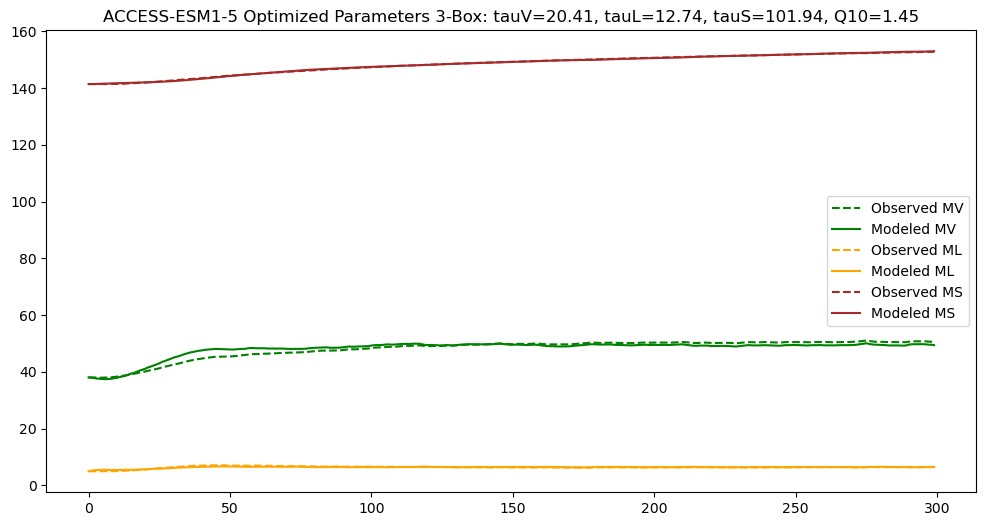

estimating parameters for model: CESM2
using 3-Box model for: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 91.32029171001479
        x: [ 8.026e-02  5.585e-01  2.291e-01  3.000e+00]
      nit: 50
      jac: [ 1.241e-02  5.485e-04 -7.640e-03 -6.447e+01]
     nfev: 335
     njev: 67
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


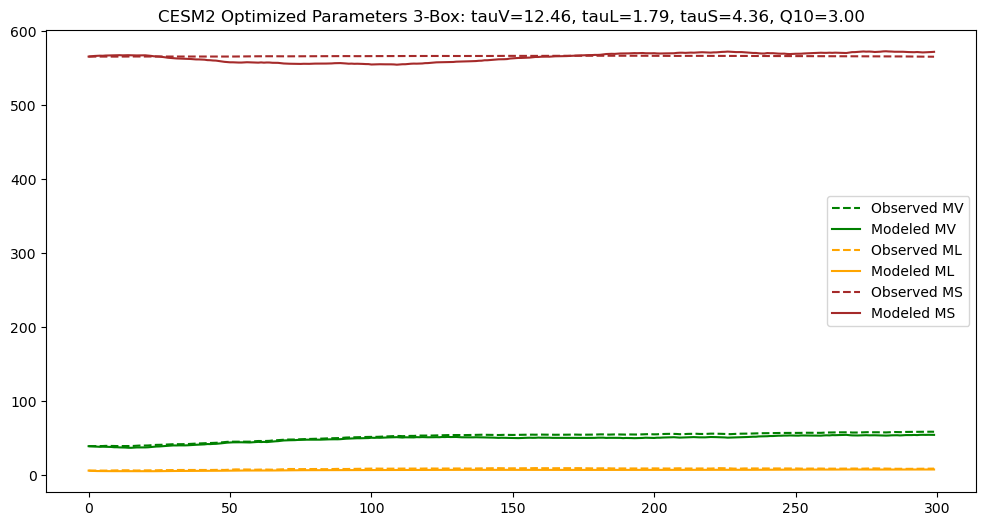

estimating parameters for model: GFDL-ESM4
using 3-Box model for: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 148.45278834837882
        x: [ 5.778e-02  2.863e-02  9.266e-01  3.000e+00]
      nit: 64
      jac: [ 9.126e-03  5.070e-03 -7.049e-04 -3.485e+01]
     nfev: 455
     njev: 91
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


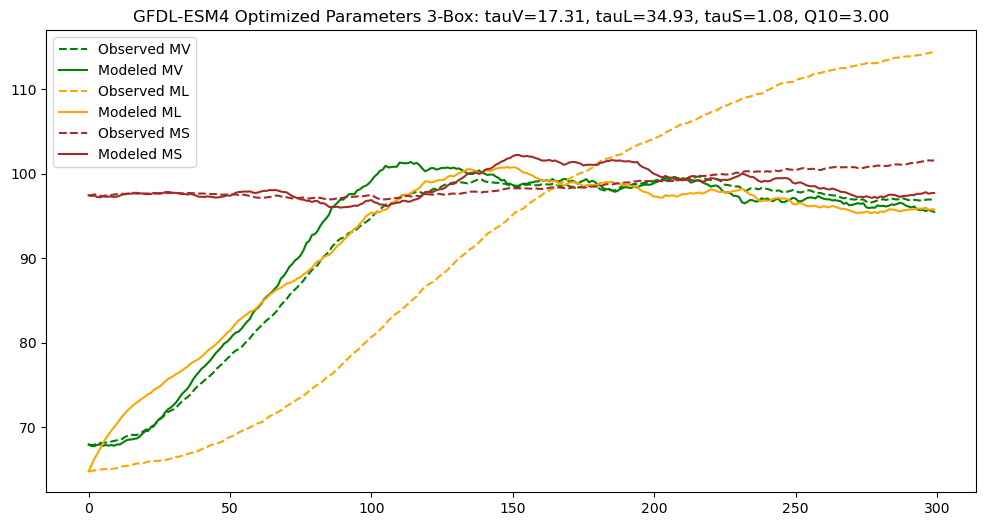

estimating parameters for model: GISS_E2.1
no litter, using 2-Box model for: GISS_E2.1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 15.971579704935552
        x: [ 4.268e-02  1.720e-03  3.000e+00]
      nit: 23
      jac: [ 1.350e-03 -9.857e-04 -1.602e-01]
     nfev: 156
     njev: 39
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


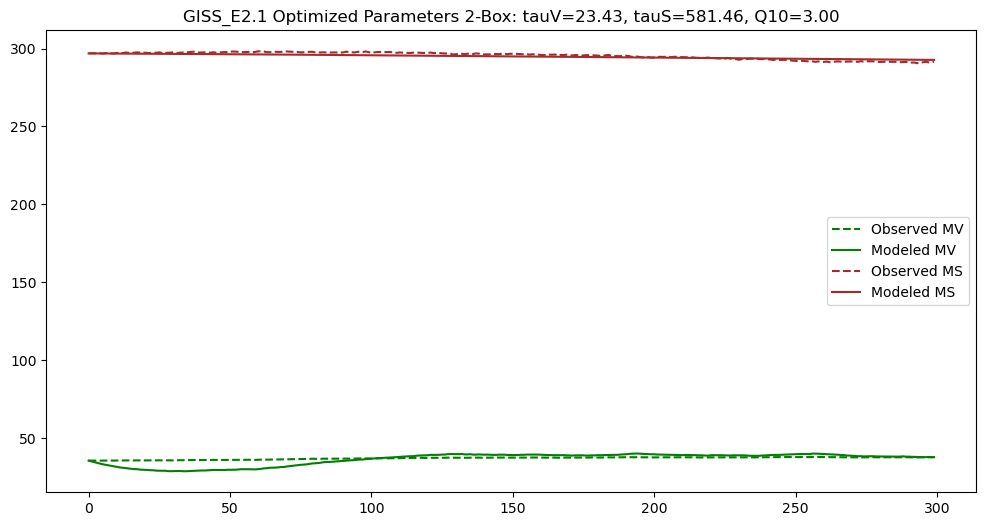

estimating parameters for model: NorESM2-LM
using 3-Box model for: NorESM2-LM
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 66.3554723618656
        x: [ 8.037e-02  6.338e-01  6.432e-02  3.000e+00]
      nit: 38
      jac: [ 1.642e-01  3.554e-03 -5.921e-01 -6.441e+01]
     nfev: 260
     njev: 52
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


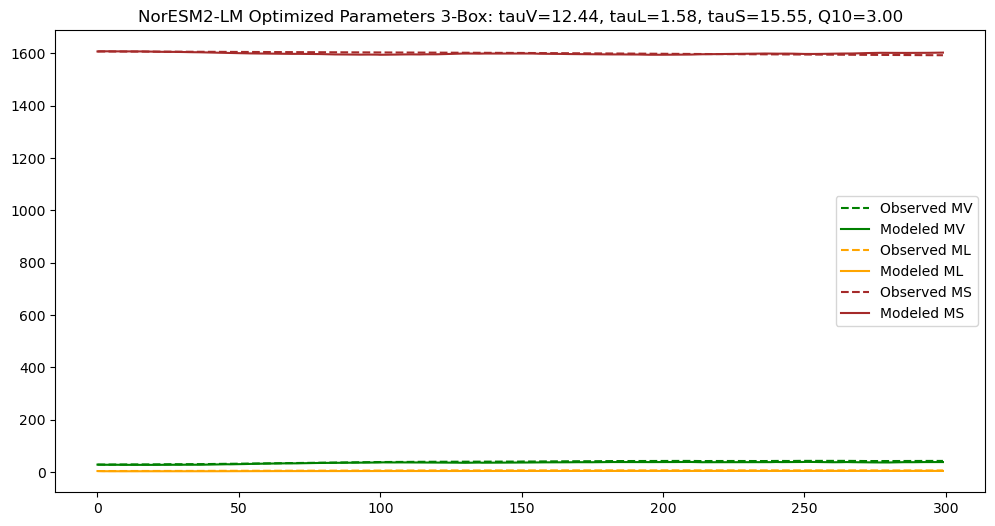

estimating parameters for model: MPI-ESM1-2-LR
using 3-Box model for: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2367.4851808474796
        x: [ 1.264e-01  5.424e-01  1.690e-01  1.664e+00]
      nit: 17
      jac: [-3.668e+03  6.705e+02  3.551e+03 -1.499e+03]
     nfev: 265
     njev: 53
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


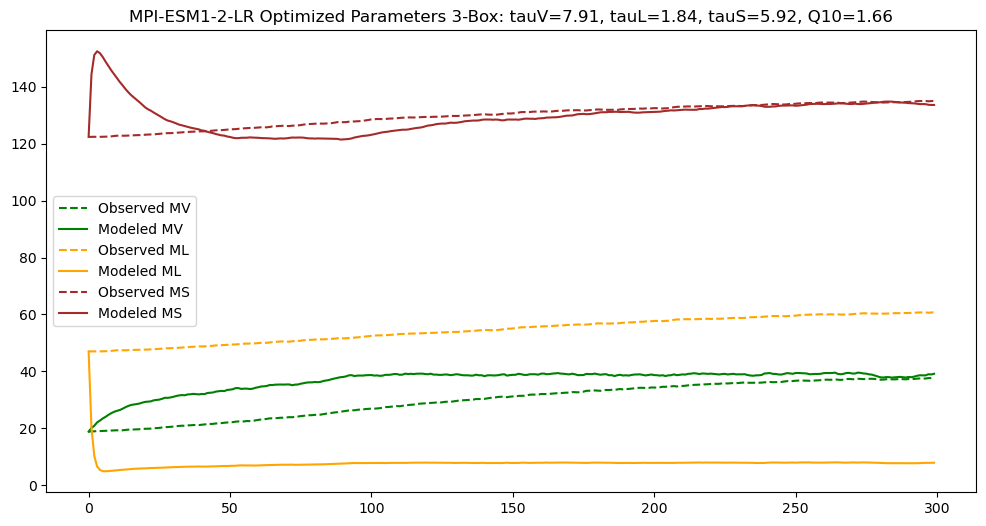

estimating parameters for model: CNRM-ESM2-1
using 3-Box model for: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 16.14722557830144
        x: [ 1.054e-01  2.039e-02  5.013e-02  2.412e+00]
      nit: 70
      jac: [-6.906e-01  1.166e+01 -4.968e+00  5.326e-01]
     nfev: 505
     njev: 101
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


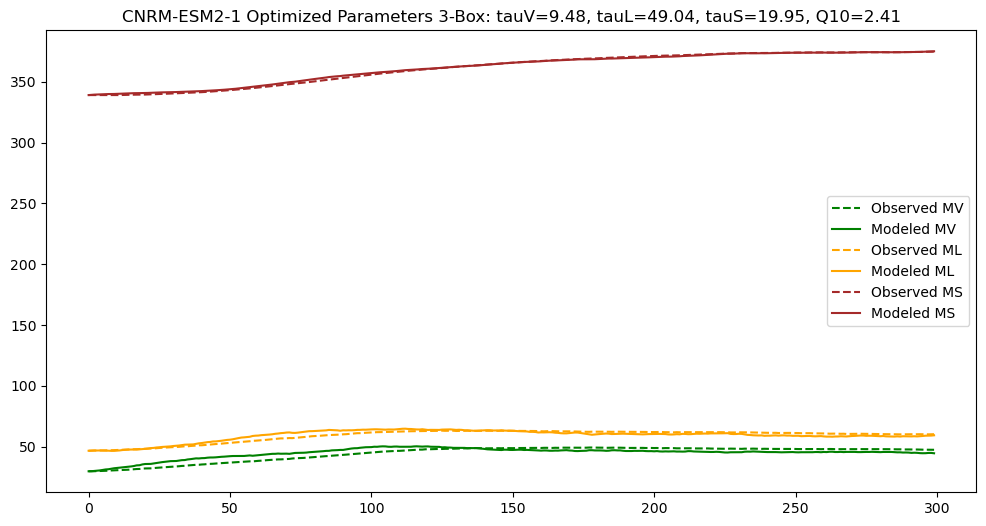

estimating parameters for model: HadCM3LC-Bris
no litter, using 2-Box model for: HadCM3LC-Bris
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1259.507722498315
        x: [ 1.343e-01  1.000e-03  3.000e+00]
      nit: 18
      jac: [ 2.638e-03  1.126e+05 -1.274e+02]
     nfev: 100
     njev: 25
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


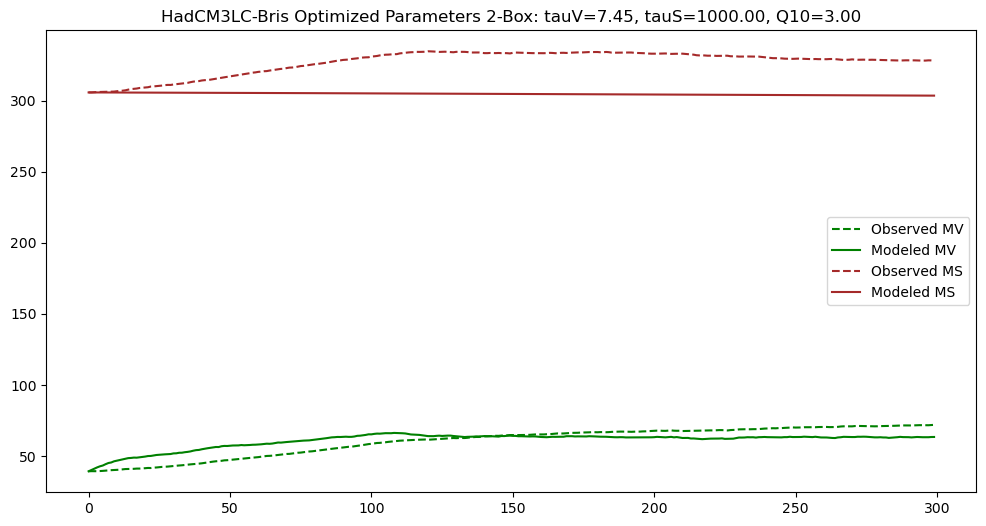

In [43]:
latrange='highlat'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year
Tb= 298.15 # base temperature (default is 25C)

# initialize some empty arrays to store outputs
fV_vec=np.empty(len(modellist))
fL_vec=np.empty(len(modellist))
fS_vec=np.empty(len(modellist))
Q10_vec=np.empty(len(modellist))

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output

    #--- cLitter
    cLitter= get_full_ts_flat10(model, experiment, 'cLitter', latrange)
    ML_obs= cLitter
    ML0=ML_obs[0] #specify initial condition
       
    #--- TAS    
    To= get_full_ts_flat10(model, experiment, 'tas', latrange)
    T = To-Tb #remove baseline temp
    
    #--- RH
    RHo= get_full_ts_flat10(model, experiment, 'rh', latrange)
    RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, experiment, 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]
    
    #--- cSoil
    cSoil= get_full_ts_flat10(model, experiment, 'cSoil', latrange)
    MS_obs= cSoil 
    MS0=MS_obs[0] # specify initial condition

    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH_obs


    # select either 3 box model or 2 box model, depending on if litter output exists
    if np.isnan(ML_obs).any():
        print('no litter, using 2-Box model for: ' +model)
        # Initial guess and bounds
        initial_guess = [0.5,0.5, 1]#first guess for [fV,fS,Q10]
        bounds = [(1e-3, 1),  (1e-3, 1), (1e-3,3)]
        
        # Run optimization
        result = minimize(objective_2box_cnstQ10_f, x0=initial_guess, bounds=bounds)
        fV_opt, fS_opt, Q10_opt = result.x
        print("Optimization Result:", result)
        
        # Simulate with optimal parameters
        MV_best, MS_best, RH_best = simulate_model_2box_cnstQ10_f(result.x)
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
        plt.plot(MV_best, label=f'Modeled MV',color='green')
        plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
        plt.plot(MS_best, label='Modeled MS',color='brown')
        plt.legend()
        plt.title(model +f' Optimized Parameters 2-Box: tauV={(1/fV_opt):.2f}, tauS={(1/fS_opt):.2f}, Q10={Q10_opt:.2f}')
        plt.show()
    
        fV_vec[m]=fV_opt
        fL_vec[m]=np.nan
        fS_vec[m]=fS_opt
        Q10_vec[m]=Q10_opt

    else: # use 3 box model
        print('using 3-Box model for: ' +model)
        # Initial guess and bounds
        initial_guess = [0.5, 0.5, 0.5, 1] # first guess for [fV,fL,fS,Q10]
        bounds = [(1e-3, 1), (1e-3, 1), (1e-3, 1), (1e-3,3)] #bounds for guesses
        
        # Run optimization
        result = minimize(objective_3box_cnstQ10_f, x0=initial_guess, bounds=bounds)
        fV_opt, fL_opt, fS_opt, Q10_opt = result.x
        print("Optimization Result:", result)
        
        # Simulate with optimal parameters
        MV_best, ML_best, MS_best, RH_best = simulate_model_3box_cnstQ10_f(result.x)
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
        plt.plot(MV_best, label=f'Modeled MV',color='green')
        plt.plot(ML_obs, label='Observed ML',color='orange',linestyle='--')
        plt.plot(ML_best, label='Modeled ML',color='orange')
        plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
        plt.plot(MS_best, label='Modeled MS',color='brown')
        plt.legend()
        plt.title(model +f' Optimized Parameters 3-Box: tauV={(1/fV_opt):.2f}, tauL={(1/fL_opt):.2f}, tauS={(1/fS_opt):.2f}, Q10={Q10_opt:.2f}')
        plt.show()
    
        fV_vec[m]=fV_opt
        fL_vec[m]=fL_opt
        fS_vec[m]=fS_opt
        Q10_vec[m]=Q10_opt
    
# #-- add output to a pandas data frame
esm_boxfit = pd.DataFrame({})
esm_boxfit['fV']=fV_vec
esm_boxfit['fL']=fL_vec
esm_boxfit['fS']=fS_vec
esm_boxfit['Q10']=Q10_vec

esm_boxfit.index=modellist

esm_boxfit_highlat_zec=esm_boxfit

estimating parameters for model: ACCESS-ESM1-5
using 3-Box model for: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 176.01009550492316
        x: [ 6.671e-02  2.534e-02  2.312e-03  3.000e+00]
      nit: 55
      jac: [-6.672e+00  6.057e-01  6.006e+00 -6.042e+00]
     nfev: 485
     njev: 97
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


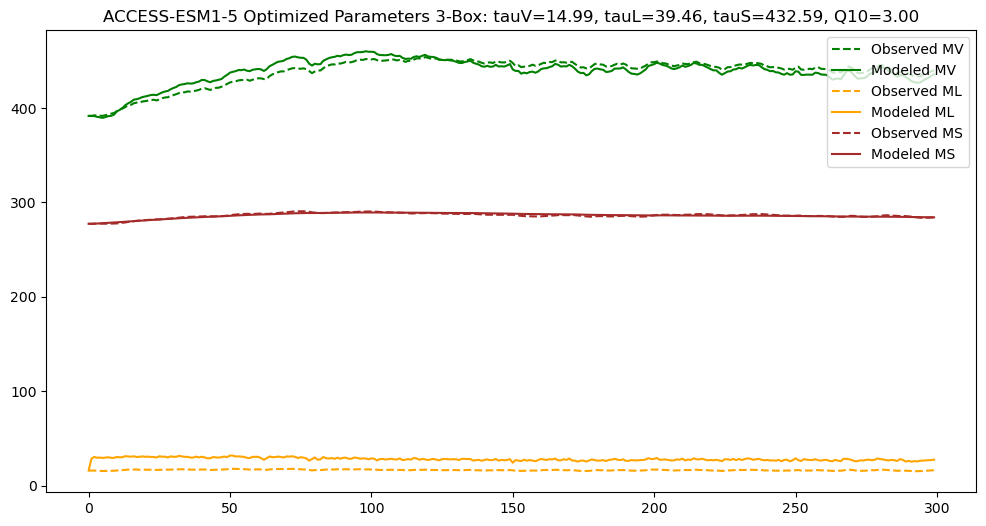

estimating parameters for model: CESM2
using 3-Box model for: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 436.0691589783563
        x: [ 5.867e-02  5.587e-02  3.487e-03  3.000e+00]
      nit: 56
      jac: [ 2.248e-02 -4.079e-01  5.938e+00 -3.776e+00]
     nfev: 445
     njev: 89
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


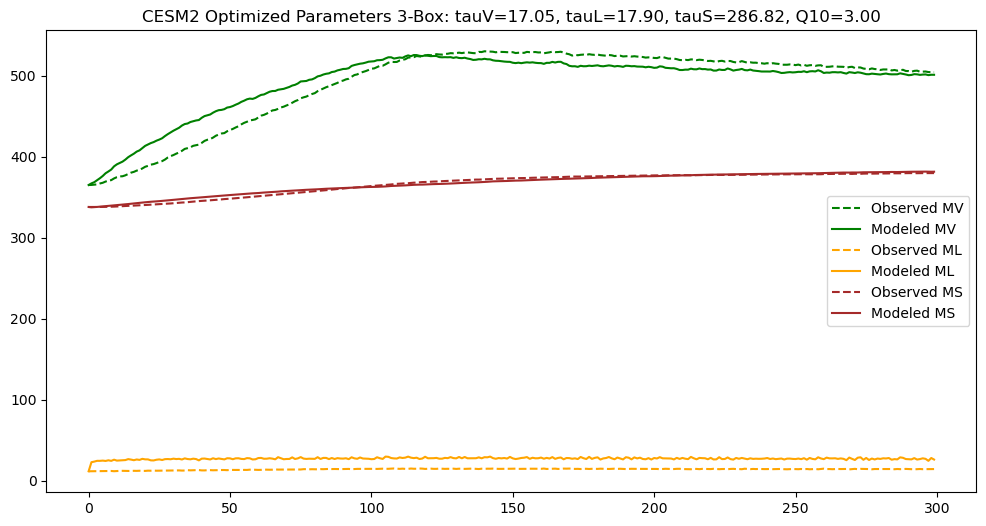

estimating parameters for model: GFDL-ESM4
using 3-Box model for: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3320.4473372658986
        x: [ 1.342e-01  1.637e-03  1.000e-03  3.000e+00]
      nit: 31
      jac: [ 1.364e-04 -1.364e-04  3.761e+02 -2.223e+02]
     nfev: 250
     njev: 50
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


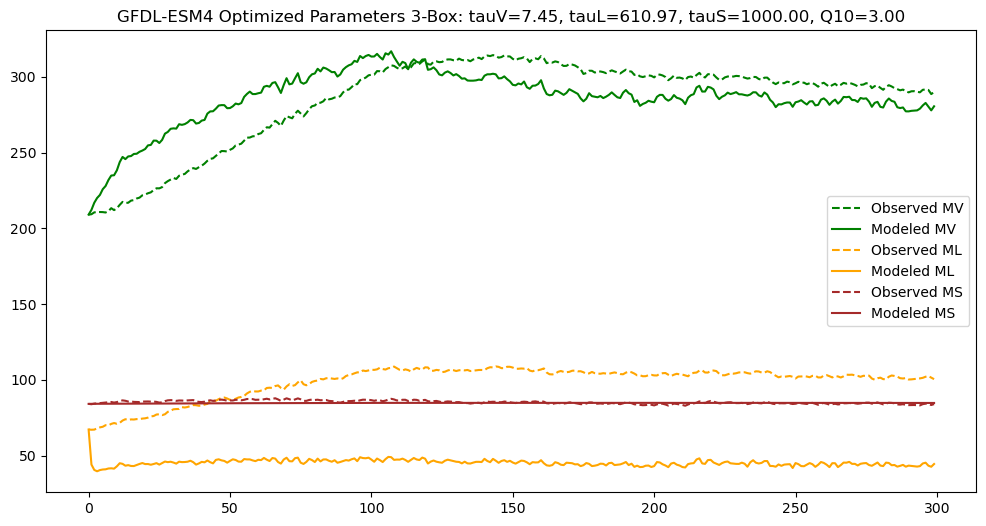

estimating parameters for model: GISS_E2.1
no litter, using 2-Box model for: GISS_E2.1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3310.6770050987607
        x: [ 8.682e-02  1.000e-03  1.000e-03]
      nit: 22
      jac: [-7.731e-04  1.586e+06  4.581e+04]
     nfev: 132
     njev: 33
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


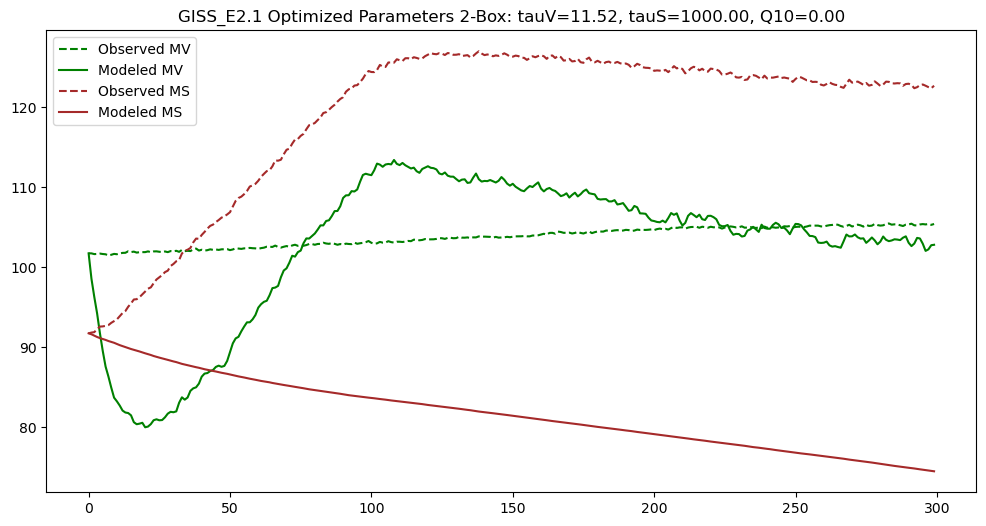

estimating parameters for model: NorESM2-LM
using 3-Box model for: NorESM2-LM
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 511.62247263630115
        x: [ 5.931e-02  1.826e-01  1.397e-02  2.588e+00]
      nit: 40
      jac: [ 1.031e+00 -7.162e-01  9.071e+00  1.006e-03]
     nfev: 370
     njev: 74
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


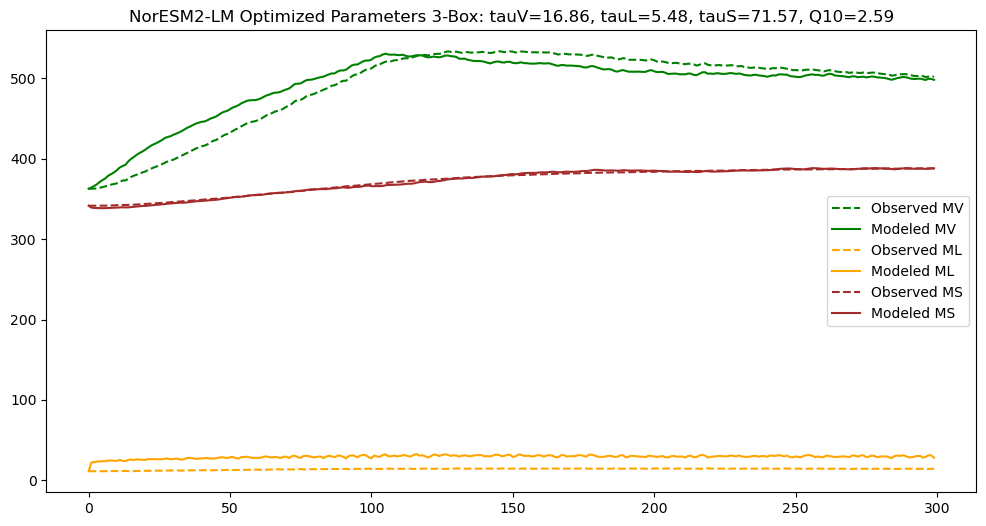

estimating parameters for model: MPI-ESM1-2-LR
using 3-Box model for: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 10695.078552200544
        x: [ 1.162e-01  4.369e-02  8.256e-03  3.000e+00]
      nit: 40
      jac: [-6.212e-01 -6.654e+00  3.195e+01 -4.186e+02]
     nfev: 375
     njev: 75
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


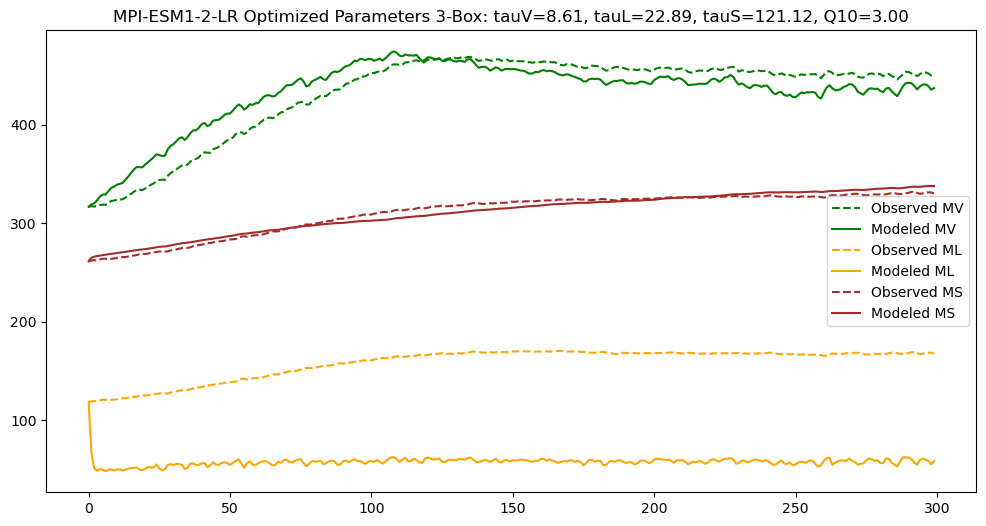

estimating parameters for model: CNRM-ESM2-1
using 3-Box model for: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2936.294660140574
        x: [ 6.141e-02  2.305e-01  1.178e-02  9.759e-01]
      nit: 44
      jac: [-4.846e+04 -4.509e+02  1.257e+04 -3.002e+02]
     nfev: 330
     njev: 66
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


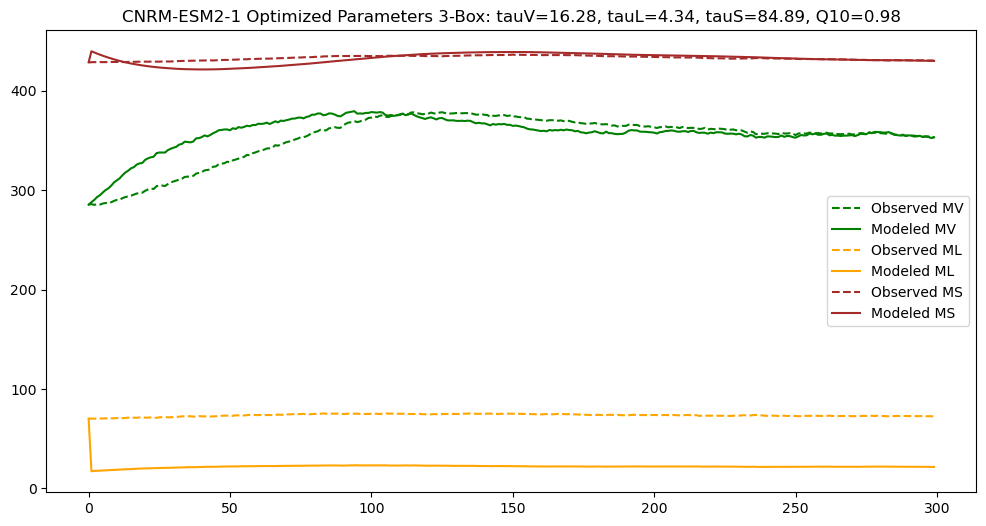

estimating parameters for model: HadCM3LC-Bris
no litter, using 2-Box model for: HadCM3LC-Bris
Optimization Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 27047.610537957124
        x: [ 9.681e-02  1.000e-03  3.000e+00]
      nit: 18
      jac: [ 0.000e+00  2.401e+07 -1.219e+03]
     nfev: 132
     njev: 33
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


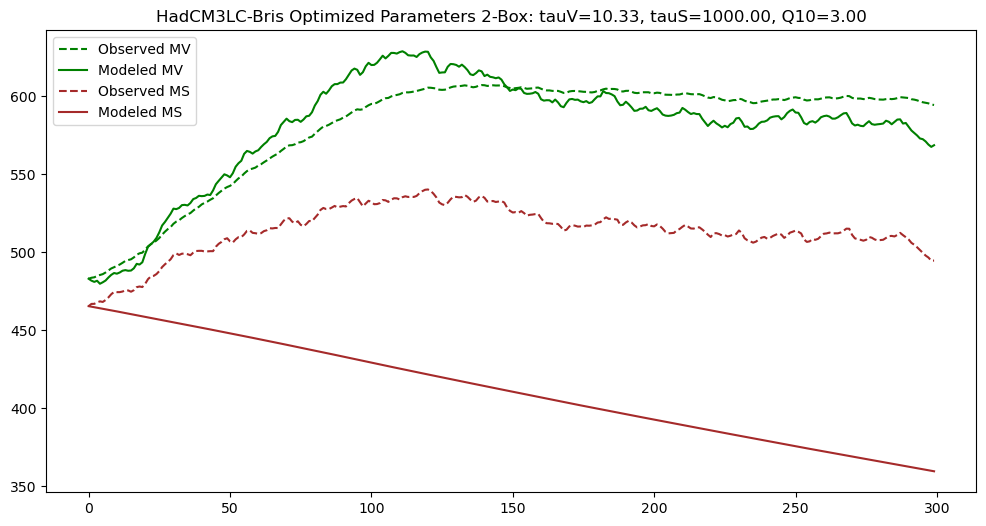

In [32]:
latrange='troplat'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year
Tb= 298.15 # base temperature (default is 25C)

# initialize some empty arrays to store outputs
fV_vec=np.empty(len(modellist))
fL_vec=np.empty(len(modellist))
fS_vec=np.empty(len(modellist))
Q10_vec=np.empty(len(modellist))

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output

    #--- cLitter
    cLitter= get_full_ts_flat10(model, experiment, 'cLitter', latrange)
    ML_obs= cLitter
    ML0=ML_obs[0] #specify initial condition
       
    #--- TAS    
    To= get_full_ts_flat10(model, experiment, 'tas', latrange)
    T = To-Tb #remove baseline temp
    
    #--- RH
    RHo= get_full_ts_flat10(model, experiment, 'rh', latrange)
    RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, experiment, 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]
    
    #--- cSoil
    cSoil= get_full_ts_flat10(model, experiment, 'cSoil', latrange)
    MS_obs= cSoil 
    MS0=MS_obs[0] # specify initial condition

    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH_obs


    # select either 3 box model or 2 box model, depending on if litter output exists
    if np.isnan(ML_obs).any():
        print('no litter, using 2-Box model for: ' +model)
        # Initial guess and bounds
        initial_guess = [0.5,0.5, 1]#first guess for [fV,fS,Q10]
        bounds = [(1e-3, 1),  (1e-3, 1), (1e-3,3)]
        
        # Run optimization
        result = minimize(objective_2box_cnstQ10_f, x0=initial_guess, bounds=bounds)
        fV_opt, fS_opt, Q10_opt = result.x
        print("Optimization Result:", result)
        
        # Simulate with optimal parameters
        MV_best, MS_best, RH_best = simulate_model_2box_cnstQ10_f(result.x)
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
        plt.plot(MV_best, label=f'Modeled MV',color='green')
        plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
        plt.plot(MS_best, label='Modeled MS',color='brown')
        plt.legend()
        plt.title(model +f' Optimized Parameters 2-Box: tauV={(1/fV_opt):.2f}, tauS={(1/fS_opt):.2f}, Q10={Q10_opt:.2f}')
        plt.show()
    
        fV_vec[m]=fV_opt
        fL_vec[m]=np.nan
        fS_vec[m]=fS_opt
        Q10_vec[m]=Q10_opt

    else: # use 3 box model
        print('using 3-Box model for: ' +model)
        # Initial guess and bounds
        initial_guess = [0.5, 0.5, 0.5, 1] # first guess for [fV,fL,fS,Q10]
        bounds = [(1e-3, 1), (1e-3, 1), (1e-3, 1), (1e-3,3)] #bounds for guesses
        
        # Run optimization
        result = minimize(objective_3box_cnstQ10_f, x0=initial_guess, bounds=bounds)
        fV_opt, fL_opt, fS_opt, Q10_opt = result.x
        print("Optimization Result:", result)
        
        # Simulate with optimal parameters
        MV_best, ML_best, MS_best, RH_best = simulate_model_3box_cnstQ10_f(result.x)
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
        plt.plot(MV_best, label=f'Modeled MV',color='green')
        plt.plot(ML_obs, label='Observed ML',color='orange',linestyle='--')
        plt.plot(ML_best, label='Modeled ML',color='orange')
        plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
        plt.plot(MS_best, label='Modeled MS',color='brown')
        plt.legend()
        plt.title(model +f' Optimized Parameters 3-Box: tauV={(1/fV_opt):.2f}, tauL={(1/fL_opt):.2f}, tauS={(1/fS_opt):.2f}, Q10={Q10_opt:.2f}')
        plt.show()
    
        fV_vec[m]=fV_opt
        fL_vec[m]=fL_opt
        fS_vec[m]=fS_opt
        Q10_vec[m]=Q10_opt
    
# #-- add output to a pandas data frame
esm_boxfit = pd.DataFrame({})
esm_boxfit['fV']=fV_vec
esm_boxfit['fL']=fL_vec
esm_boxfit['fS']=fS_vec
esm_boxfit['Q10']=Q10_vec

esm_boxfit.index=modellist

esm_boxfit_troplat_zec=esm_boxfit

estimating parameters for model: ACCESS-ESM1-5
using 3-Box model for: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 14.969353694645102
        x: [ 6.723e-02  2.167e-01  2.350e-02  1.454e+00]
      nit: 66
      jac: [-3.735e-01 -7.240e-02  8.234e-01 -3.749e-02]
     nfev: 550
     njev: 110
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


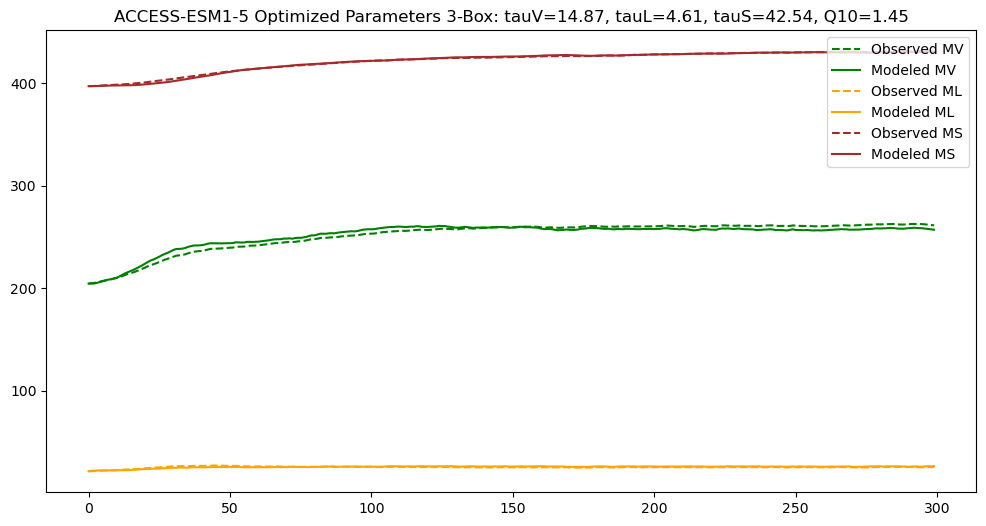

estimating parameters for model: CESM2
using 3-Box model for: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 150.41672788966324
        x: [ 7.282e-02  5.807e-01  1.326e-01  3.000e+00]
      nit: 40
      jac: [ 9.697e-02 -1.859e-03  5.339e-02 -5.383e+01]
     nfev: 275
     njev: 55
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


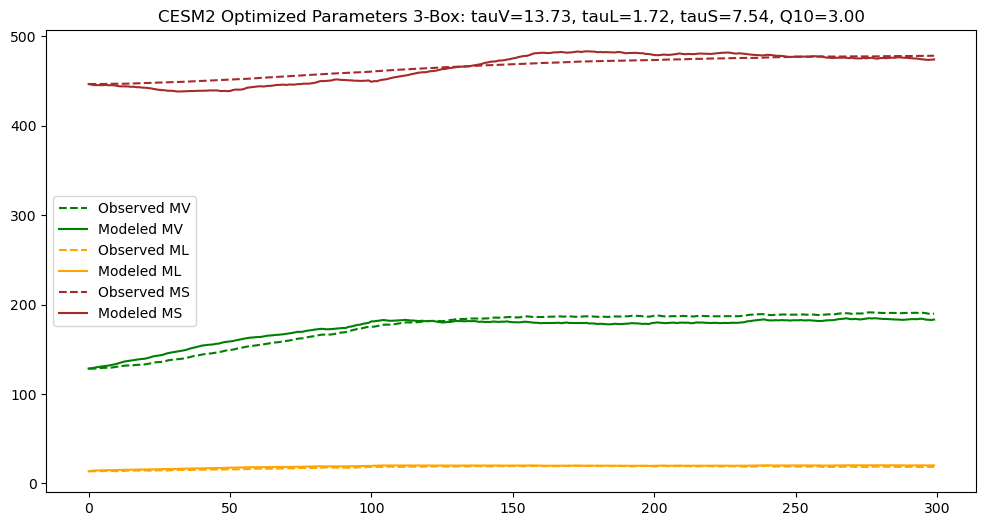

estimating parameters for model: GFDL-ESM4
using 3-Box model for: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 201.9743296936498
        x: [ 7.640e-02  3.622e-03  1.617e-02  2.954e+00]
      nit: 51
      jac: [-1.646e+01  5.519e+01 -9.949e+00 -4.272e-01]
     nfev: 440
     njev: 88
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


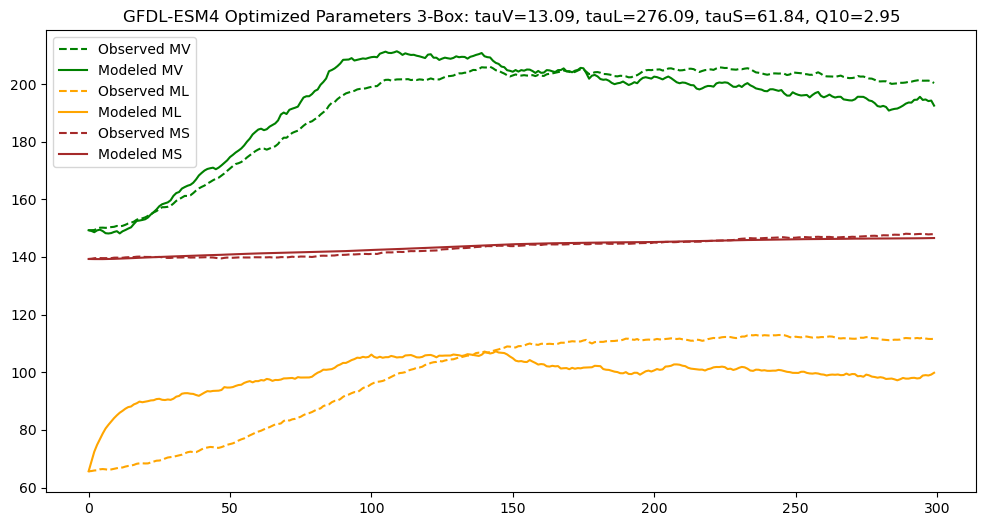

estimating parameters for model: GISS_E2.1
no litter, using 2-Box model for: GISS_E2.1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3262.4398192709823
        x: [ 5.222e-02  1.000e-03  3.000e+00]
      nit: 8
      jac: [ 3.347e-02  1.747e+06 -1.034e+03]
     nfev: 160
     njev: 40
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


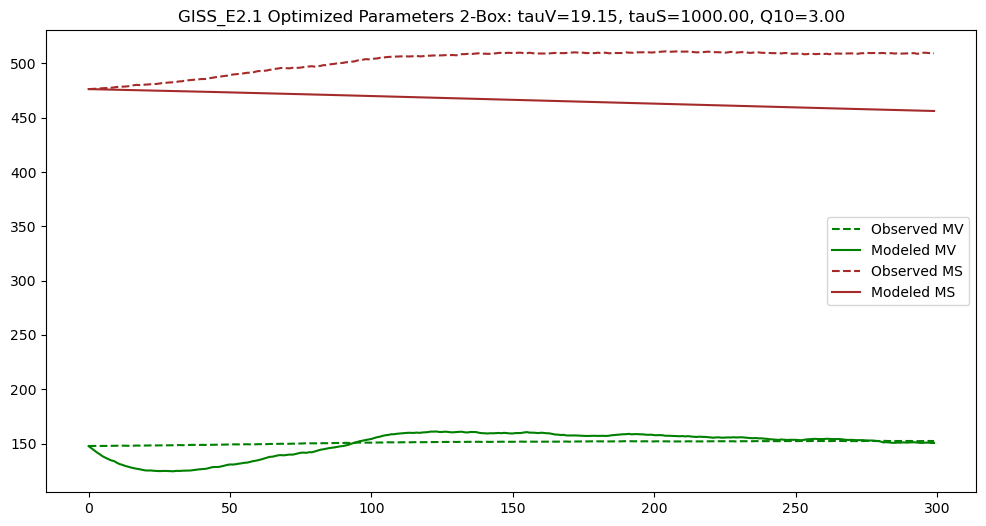

estimating parameters for model: NorESM2-LM
using 3-Box model for: NorESM2-LM
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 121.33088795308963
        x: [ 7.001e-02  5.791e-01  1.440e-01  3.000e+00]
      nit: 41
      jac: [ 1.650e-02 -3.273e-03  4.126e-02 -7.319e+01]
     nfev: 275
     njev: 55
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


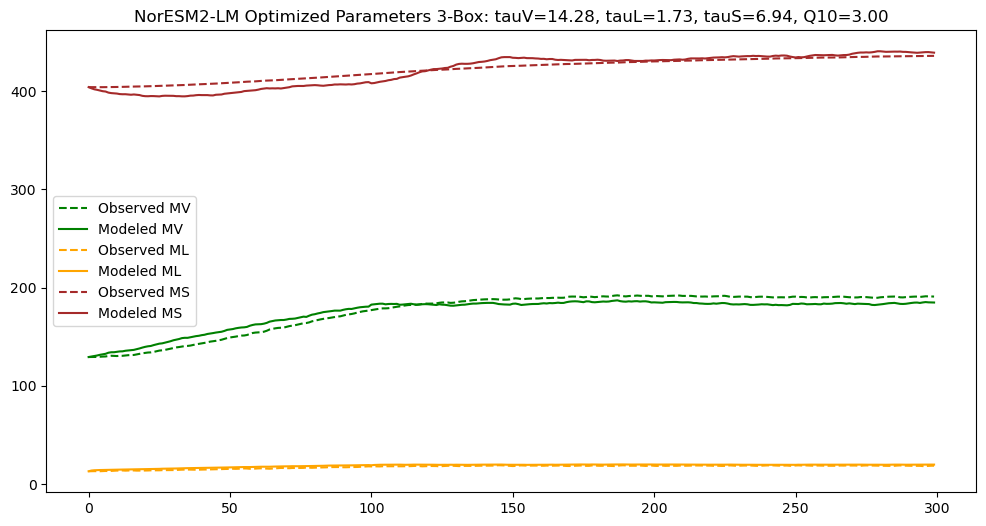

estimating parameters for model: MPI-ESM1-2-LR
using 3-Box model for: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 75.97949432180948
        x: [ 1.942e-01  1.626e-02  3.462e-02  2.790e+00]
      nit: 52
      jac: [-1.563e-03  1.029e-02 -5.049e-03  4.320e-04]
     nfev: 350
     njev: 70
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


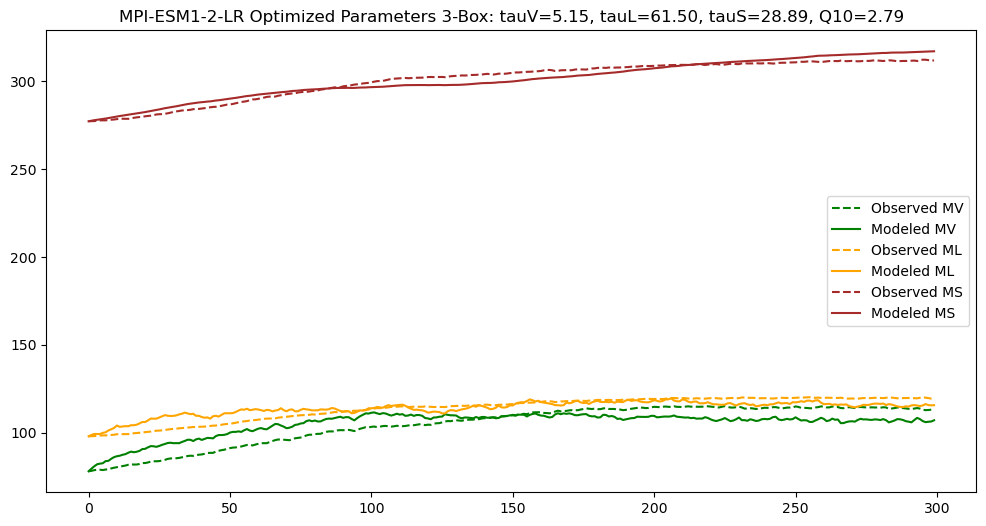

estimating parameters for model: CNRM-ESM2-1
using 3-Box model for: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 871.6078331159362
        x: [ 5.492e-02  4.571e-03  1.000e-03  3.000e+00]
      nit: 68
      jac: [-2.956e-03 -2.046e-04  1.276e+04 -2.192e+03]
     nfev: 560
     njev: 112
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


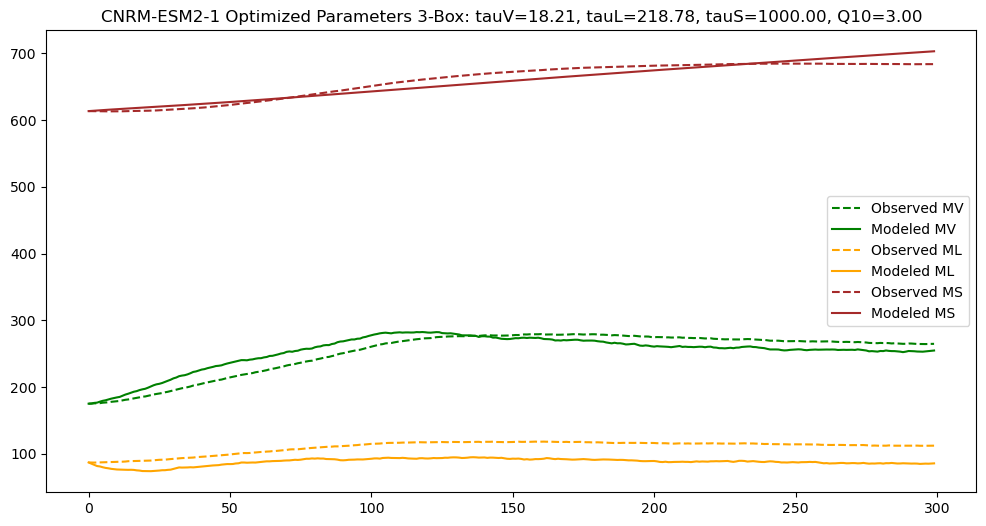

estimating parameters for model: HadCM3LC-Bris
no litter, using 2-Box model for: HadCM3LC-Bris
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 8372.380017968206
        x: [ 1.824e-01  1.000e-03  3.000e+00]
      nit: 9
      jac: [-7.458e-03  3.298e+06 -1.970e+03]
     nfev: 104
     njev: 26
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


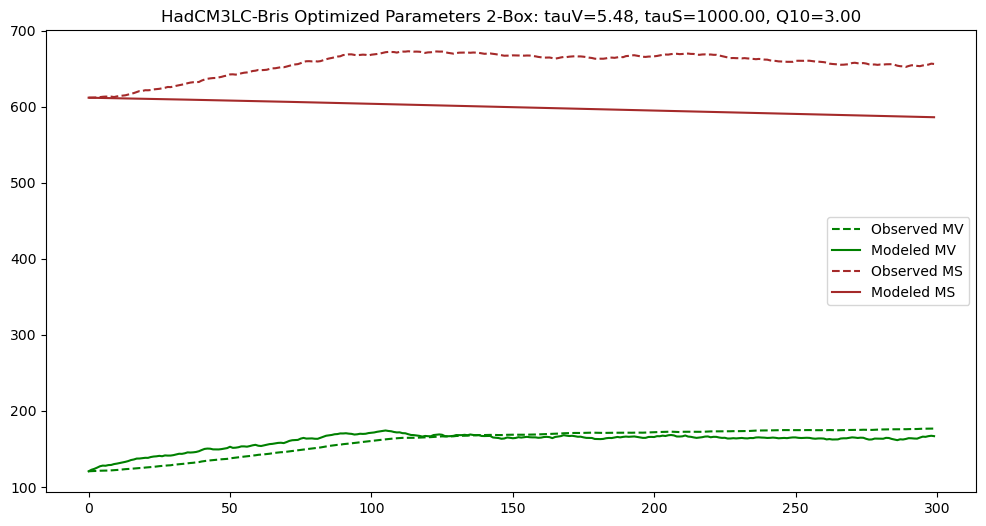

In [41]:
latrange='midlat'
experiment='flat10_zec'


modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM



dt=1 # timestep is 1 year
Tb= 298.15 # base temperature (default is 25C)

# initialize some empty arrays to store outputs
fV_vec=np.empty(len(modellist))
fL_vec=np.empty(len(modellist))
fS_vec=np.empty(len(modellist))
Q10_vec=np.empty(len(modellist))

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output

    #--- cLitter
    cLitter= get_full_ts_flat10(model, experiment, 'cLitter', latrange)
    ML_obs= cLitter
    ML0=ML_obs[0] #specify initial condition
       
    #--- TAS    
    To= get_full_ts_flat10(model, experiment, 'tas', latrange)
    T = To-Tb #remove baseline temp
    
    #--- RH
    RHo= get_full_ts_flat10(model, experiment, 'rh', latrange)
    RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, experiment, 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, experiment, 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]
    
    #--- cSoil
    cSoil= get_full_ts_flat10(model, experiment, 'cSoil', latrange)
    MS_obs= cSoil 
    MS0=MS_obs[0] # specify initial condition

    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH_obs


    # select either 3 box model or 2 box model, depending on if litter output exists
    if np.isnan(ML_obs).any():
        print('no litter, using 2-Box model for: ' +model)
        # Initial guess and bounds
        initial_guess = [0.5,0.5, 1]#first guess for [fV,fS,Q10]
        bounds = [(1e-3, 1),  (1e-3, 1), (1e-3,3)]
        
        # Run optimization
        result = minimize(objective_2box_cnstQ10_f, x0=initial_guess, bounds=bounds)
        fV_opt, fS_opt, Q10_opt = result.x
        print("Optimization Result:", result)
        
        # Simulate with optimal parameters
        MV_best, MS_best, RH_best = simulate_model_2box_cnstQ10_f(result.x)
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
        plt.plot(MV_best, label=f'Modeled MV',color='green')
        plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
        plt.plot(MS_best, label='Modeled MS',color='brown')
        plt.legend()
        plt.title(model +f' Optimized Parameters 2-Box: tauV={(1/fV_opt):.2f}, tauS={(1/fS_opt):.2f}, Q10={Q10_opt:.2f}')
        plt.show()
    
        fV_vec[m]=fV_opt
        fL_vec[m]=np.nan
        fS_vec[m]=fS_opt
        Q10_vec[m]=Q10_opt

    else: # use 3 box model
        print('using 3-Box model for: ' +model)
        # Initial guess and bounds
        initial_guess = [0.5, 0.5, 0.5, 1] # first guess for [fV,fL,fS,Q10]
        bounds = [(1e-3, 1), (1e-3, 1), (1e-3, 1), (1e-3,3)] #bounds for guesses
        
        # Run optimization
        result = minimize(objective_3box_cnstQ10_f, x0=initial_guess, bounds=bounds)
        fV_opt, fL_opt, fS_opt, Q10_opt = result.x
        print("Optimization Result:", result)
        
        # Simulate with optimal parameters
        MV_best, ML_best, MS_best, RH_best = simulate_model_3box_cnstQ10_f(result.x)
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
        plt.plot(MV_best, label=f'Modeled MV',color='green')
        plt.plot(ML_obs, label='Observed ML',color='orange',linestyle='--')
        plt.plot(ML_best, label='Modeled ML',color='orange')
        plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
        plt.plot(MS_best, label='Modeled MS',color='brown')
        plt.legend()
        plt.title(model +f' Optimized Parameters 3-Box: tauV={(1/fV_opt):.2f}, tauL={(1/fL_opt):.2f}, tauS={(1/fS_opt):.2f}, Q10={Q10_opt:.2f}')
        plt.show()
    
        fV_vec[m]=fV_opt
        fL_vec[m]=fL_opt
        fS_vec[m]=fS_opt
        Q10_vec[m]=Q10_opt
    
# #-- add output to a pandas data frame
esm_boxfit = pd.DataFrame({})
esm_boxfit['fV']=fV_vec
esm_boxfit['fL']=fL_vec
esm_boxfit['fS']=fS_vec
esm_boxfit['Q10']=Q10_vec

esm_boxfit.index=modellist

esm_boxfit_midlat_zec=esm_boxfit

In [36]:
esm_boxfit

,fV,fL,fS,Q10
ACCESS-ESM1-5,0.066628,0.268820,0.022632,1.176986
CESM2,0.064119,1.000000,0.153724,3.000000
GFDL-ESM4,0.104586,0.001344,0.005444,2.743285
GISS_E2.1,0.063279,NaN,0.001000,3.000000
NorESM2-LM,0.065063,0.721237,0.079506,3.000000
MPI-ESM1-2-LR,0.131773,0.025052,0.050333,2.710045
CNRM-ESM2-1,0.063194,0.003666,0.001000,3.000000
HadCM3LC-Bris,0.116207,NaN,0.001000,3.000000


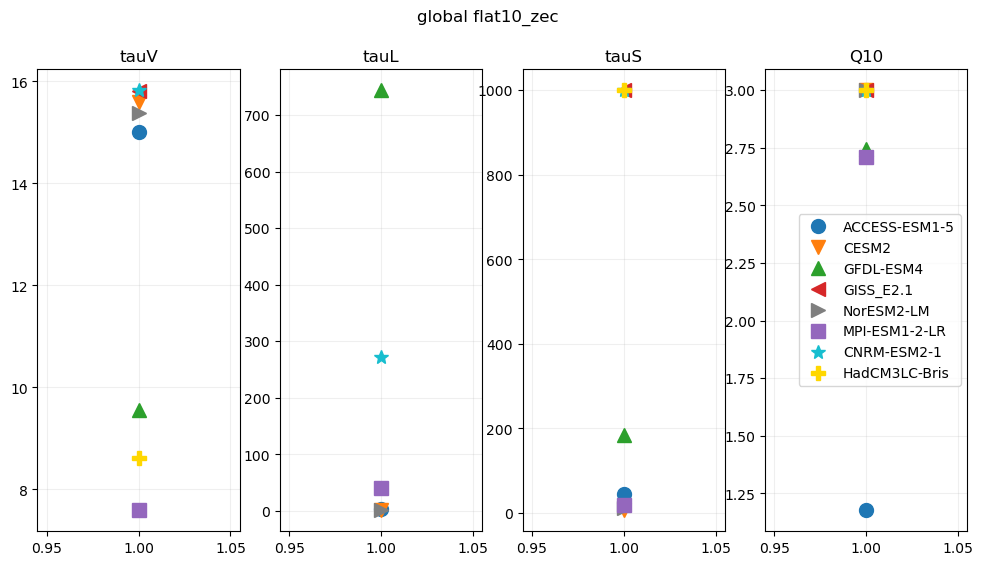

In [37]:
latrange='global'
experiment='flat10_zec'

esm_boxfit = esm_boxfit_global_zec

fig, ax =plt.subplots(1,4,figsize=(12, 6))

for m in range(len(modellist)):
    model=modellist[m]
    
    ax[0].plot(1, 1/esm_boxfit['fV'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[1].plot(1, 1/esm_boxfit['fL'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[2].plot(1, 1/esm_boxfit['fS'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[3].plot(1, esm_boxfit['Q10'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)


ax[0].set_title('tauV')
ax[1].set_title('tauL')
ax[2].set_title('tauS')
ax[3].set_title('Q10')

ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)
ax[2].grid(alpha=0.2)
ax[3].grid(alpha=0.2)

ax[3].legend()

fig.suptitle(latrange +' ' +experiment)

plt.savefig('figures/box_model_params_fit_' +latrange +'_' +experiment +'.pdf', bbox_inches='tight')



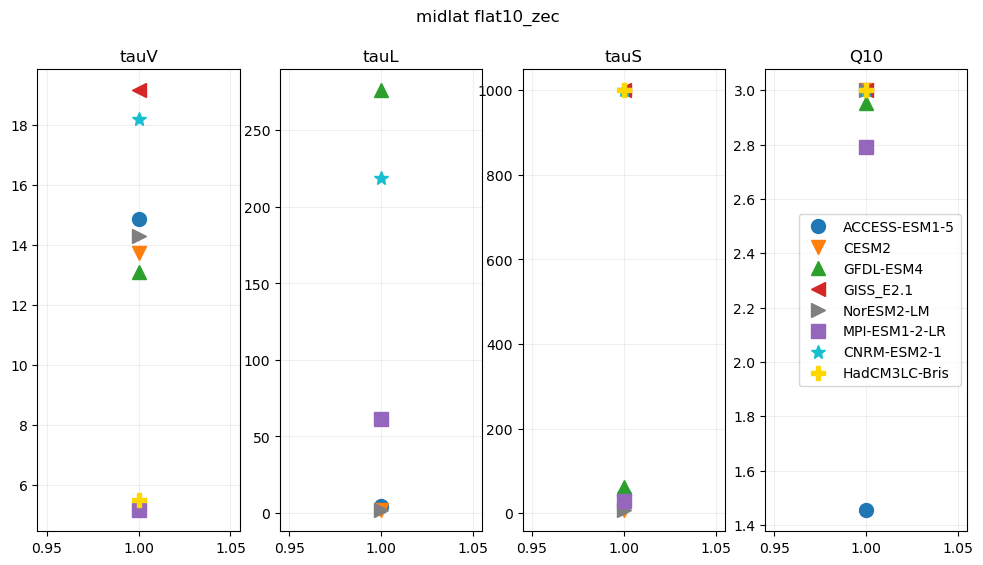

In [42]:
latrange='midlat'
experiment='flat10_zec'

esm_boxfit = esm_boxfit_midlat_zec


fig, ax =plt.subplots(1,4,figsize=(12, 6))

for m in range(len(modellist)):
    model=modellist[m]
    
    ax[0].plot(1, 1/esm_boxfit['fV'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[1].plot(1, 1/esm_boxfit['fL'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[2].plot(1, 1/esm_boxfit['fS'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[3].plot(1, esm_boxfit['Q10'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)


ax[0].set_title('tauV')
ax[1].set_title('tauL')
ax[2].set_title('tauS')
ax[3].set_title('Q10')

ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)
ax[2].grid(alpha=0.2)
ax[3].grid(alpha=0.2)

ax[3].legend()

fig.suptitle(latrange +' ' +experiment)

plt.savefig('figures/box_model_params_fit_' +latrange +'_' +experiment +'.pdf', bbox_inches='tight')



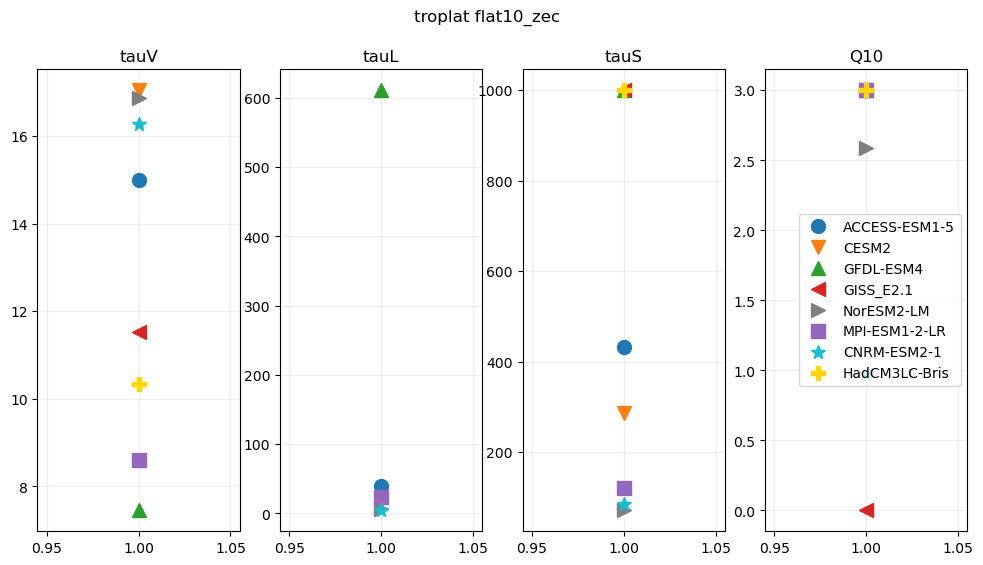

In [38]:
latrange='troplat'
experiment='flat10_zec'

esm_boxfit = esm_boxfit_troplat_zec


fig, ax =plt.subplots(1,4,figsize=(12, 6))

for m in range(len(modellist)):
    model=modellist[m]
    
    ax[0].plot(1, 1/esm_boxfit['fV'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[1].plot(1, 1/esm_boxfit['fL'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[2].plot(1, 1/esm_boxfit['fS'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[3].plot(1, esm_boxfit['Q10'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)


ax[0].set_title('tauV')
ax[1].set_title('tauL')
ax[2].set_title('tauS')
ax[3].set_title('Q10')

ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)
ax[2].grid(alpha=0.2)
ax[3].grid(alpha=0.2)

ax[3].legend()

fig.suptitle(latrange +' ' +experiment)

plt.savefig('figures/box_model_params_fit_' +latrange +'_' +experiment +'.pdf', bbox_inches='tight')



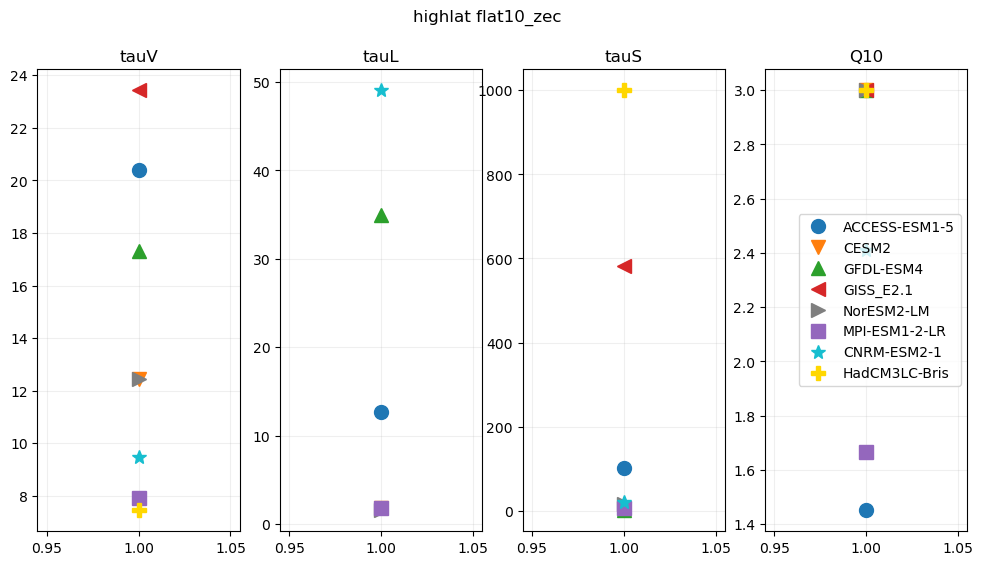

In [44]:
latrange='highlat'
experiment='flat10_zec'

esm_boxfit = esm_boxfit_highlat_zec


fig, ax =plt.subplots(1,4,figsize=(12, 6))

for m in range(len(modellist)):
    model=modellist[m]
    
    ax[0].plot(1, 1/esm_boxfit['fV'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[1].plot(1, 1/esm_boxfit['fL'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[2].plot(1, 1/esm_boxfit['fS'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)
    ax[3].plot(1, esm_boxfit['Q10'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10)


ax[0].set_title('tauV')
ax[1].set_title('tauL')
ax[2].set_title('tauS')
ax[3].set_title('Q10')

ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)
ax[2].grid(alpha=0.2)
ax[3].grid(alpha=0.2)

ax[3].legend()

fig.suptitle(latrange +' ' +experiment)

plt.savefig('figures/box_model_params_fit_' +latrange +'_' +experiment +'.pdf', bbox_inches='tight')



# Box Model without optimized parameters

### Tune the parameters by hand for a single model

In [ ]:
## One model by hand 

model=['GFDL-ESM4']

# Tune Constants By Hand

tauV= 9.1 # years
tauL= 15 #
tauS= 6
Q10= 2

In [68]:
## One model by hand 

model=['CESM2']

# Tune Constants By Hand

latrange='global'
tauV= 15.7 # years
tauL= 1 #
tauS= 8
Q10= 2.64

# latrange='highlat'
# tauV= 14 # years
# tauL= 1 #
# tauS= 150
# Q10= 1


# latrange='troplat'
# tauV= 17 # years
# tauL= .5
# tauS= 7
# Q10= 3

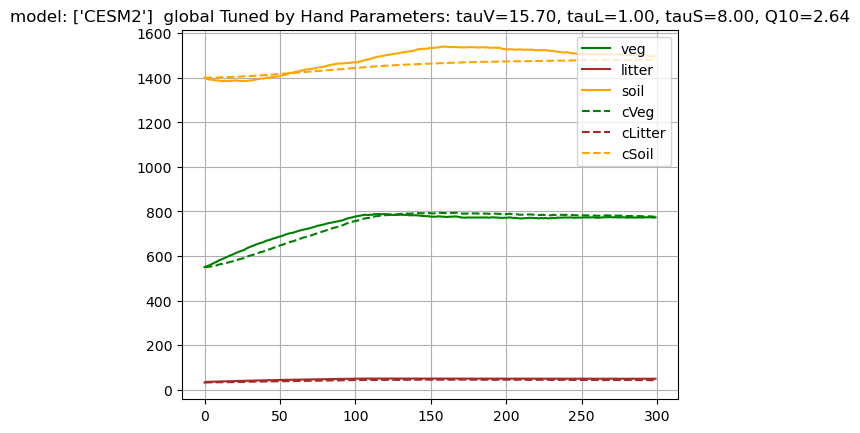

In [69]:
# run the box model


dt=1 # timestep is 1 year
Tb= 298.15 # base temperature (default is 25C)


fV=1/tauV
fL=1/tauL
fS=1/tauS


#--- cLitter
cLitter= get_full_ts_flat10(model, 'flat10_zec', 'cLitter', latrange)
ML_obs= cLitter
ML0=ML_obs[0] #specify initial condition

if np.isnan(ML_obs).any():
    print('no litter')


# #--- GPP
# GPPo = get_full_ts_flat10(model, 'flat10_zec', 'gpp', latrange)
# GPP= GPPo *  speryr #convert from Pg/s to Pg/yr

#--- TAS    
To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
T = To-Tb #remove baseline temp

#--- RH
RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr

#--- NBP
NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
NBP= NBPo *  speryr #convert from Pg/s to Pg/yr

#--- cVeg  
cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
MV_obs= cVeg 
MV0=MV_obs[0]

#--- cSoil
cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
MS_obs= cSoil 
MS0=MS_obs[0] # specify initial condition


# calculate NPP from nbp and rh 
NPP=NBP + RH_obs


# specify length of time series
yrs= np.arange(len(T))

# Integrate forward

# dMVdt= fa*gpp -MV/tauV
# dMLdt=MV/tauV - ML/tauL - ML*Q10vec
# dMSdt=ML/tauL - MS*Q10vec

# initalize empty arrays
MV=np.empty(len(yrs))
MV[0]=MV0
ML=np.empty(len(yrs))
ML[0]=ML0
MS=np.empty(len(yrs))
MS[0]=MS0

for y in yrs[1:]:
   
    MV[y]=MV[y-1] + dt*(NPP[y]-fV*MV[y-1])
    ML[y]=ML[y-1] + dt*(fV*MV[y-1] - fL*ML[y-1] - (1-fL)*ML[y-1]*Q10**(T[y]/10))
    MS[y]=MS[y-1] + dt*(fL*ML[y-1] - fS*MS[y-1]*Q10**(T[y]/10))

plt.plot(MV,label='veg',color='green')
plt.plot(ML,label='litter',color='brown')
plt.plot(MS,label='soil',color='orange')

plt.plot(MV_obs,label='cVeg',linestyle='--',color='green')
plt.plot(ML_obs,label='cLitter',linestyle='--',color='brown')
plt.plot(MS_obs,label='cSoil',linestyle='--',color='orange') 

plt.title(f'model: {model}  {latrange} Tuned by Hand Parameters: tauV={tauV:.2f}, tauL={tauL:.2f}, tauS={tauS:.2f}, Q10={Q10:.2f}')

#plt.ylim([500, 800])

plt.grid()
plt.legend()

## Tune by hand, 2 box

In [47]:
## One model by hand 

## NO NBP FOR UKESM

model=['UKESM1.2']

# Tune Constants By Hand

tauV= 9.1 # years
tauS= 6
Q10= 2

In [101]:
## One model by hand

model=['HadCM3LC-Bris']

# Tune Constants By Hand

fV_m= esm_boxfit_global_zec['fV'][model].values  #9.1 # years
fS_m= esm_boxfit_global_zec['fS'][model].values  #6
tauV=1/fV_m[0]
tauS=1/fS_m[0]

Q10= 0.38691293
tauS=70

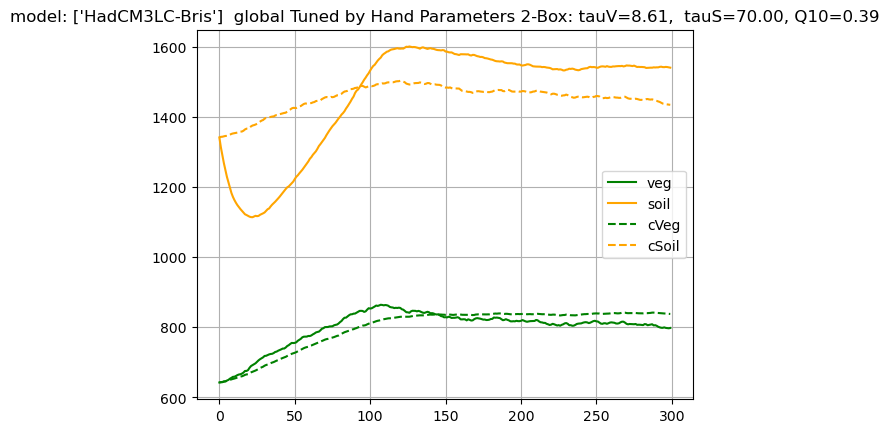

In [102]:
# run the box model


dt=1 # timestep is 1 year
Tb= 298.15 # base temperature (default is 25C)


fV=1/tauV
fS=1/tauS


#--- TAS    
To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
T = To-Tb #remove baseline temp

#--- RH
RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr

#--- NBP
NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
NBP= NBPo *  speryr #convert from Pg/s to Pg/yr

#--- cVeg  
cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
MV_obs= cVeg 
MV0=MV_obs[0]

#--- cSoil
cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
MS_obs= cSoil 
MS0=MS_obs[0] # specify initial condition


# calculate NPP from nbp and rh 
NPP=NBP + RH_obs


# specify length of time series
yrs= np.arange(len(T))

# Integrate forward

# dMVdt= fa*gpp -MV/tauV
# dMLdt=MV/tauV - ML/tauL - ML*Q10vec
# dMSdt=ML/tauL - MS*Q10vec

# initalize empty arrays
MV=np.empty(len(yrs))
MV[0]=MV0
MS=np.empty(len(yrs))
MS[0]=MS0

for y in yrs[1:]:
   
    MV[y]=MV[y-1] + dt*(NPP[y]-fV*MV[y-1])
    MS[y]=MS[y-1] + dt*(fV*MV[y-1] - fS*MS[y-1]*Q10**(T[y]/10))

plt.plot(MV,label='veg',color='green')
plt.plot(MS,label='soil',color='orange')

plt.plot(MV_obs,label='cVeg',linestyle='--',color='green')
plt.plot(MS_obs,label='cSoil',linestyle='--',color='orange') 

plt.title(f'model: {model}  {latrange} Tuned by Hand Parameters 2-Box: tauV={tauV:.2f},  tauS={tauS:.2f}, Q10={Q10:.2f}')

#plt.ylim([500, 800])

plt.grid()
plt.legend()

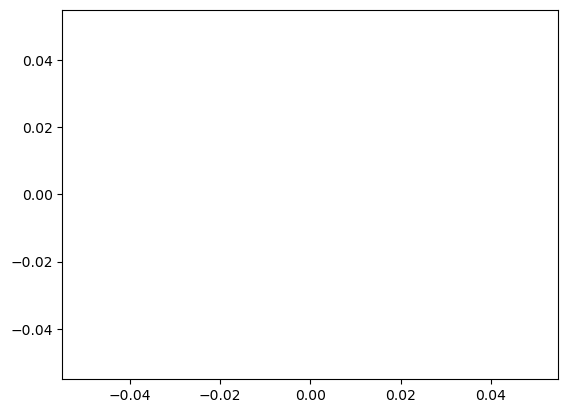

In [49]:
plt.plot(NBP)

## estimate the implied Q10 given estimated tau parameters

$Q_{10}$ can be estimated directly from RH, T, and the rate constants fL and fS

$Q_{10} = exp \Big[\frac{10}{T}log \Big(\frac{RH}{(1-f_L)\cdot M_L + f_S \cdot M_S}\Big)\Big]$

In [50]:
esm_boxfit_global_zec



,fV,fL,fS,Q10
ACCESS-ESM1-5,0.066628,0.268820,0.022632,1.176986
CESM2,0.064119,1.000000,0.153724,3.000000
GFDL-ESM4,0.104586,0.001344,0.005444,2.743285
GISS_E2.1,0.063279,NaN,0.001000,3.000000
NorESM2-LM,0.065063,0.721237,0.079506,3.000000
MPI-ESM1-2-LR,0.131773,0.025052,0.050333,2.710045
CNRM-ESM2-1,0.063194,0.003666,0.001000,3.000000
HadCM3LC-Bris,0.116207,NaN,0.001000,3.000000


estimating parameters for model: ACCESS-ESM1-5 flat10_zec
estimating parameters for model: CESM2 flat10_zec
estimating parameters for model: GFDL-ESM4 flat10_zec
estimating parameters for model: GISS_E2.1 flat10_zec
estimating parameters for model: NorESM2-LM flat10_zec
estimating parameters for model: MPI-ESM1-2-LR flat10_zec
estimating parameters for model: CNRM-ESM2-1 flat10_zec
estimating parameters for model: HadCM3LC-Bris flat10_zec


Text(0.5, 0, 'years')

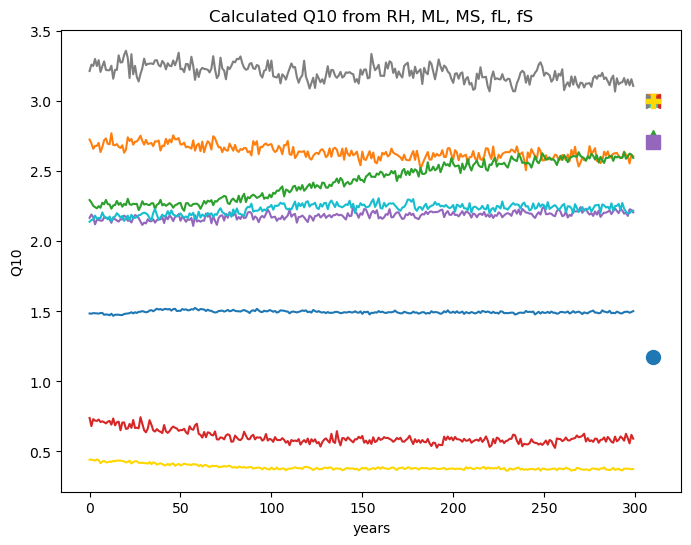

In [62]:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']#,
            #'UKESM1.2'] # no NPB for UKESM

esm_boxfit=esm_boxfit_global_zec

plt.figure(figsize=(8, 6))

Q10_calc=np.empty(len(modellist))

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model +' ' +experiment)

    # assign data from output

    #--- cLitter
    cLitter= get_full_ts_flat10(model, experiment, 'cLitter', latrange)
    ML_obs= cLitter
          
    #--- TAS    
    To= get_full_ts_flat10(model, experiment, 'tas', latrange)
    T = To-Tb #remove baseline temp
    
    #--- RH
    RHo= get_full_ts_flat10(model, experiment, 'rh', latrange)
    RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr
        
    #--- cSoil
    cSoil= get_full_ts_flat10(model, experiment, 'cSoil', latrange)
    MS_obs= cSoil 

    # assign parameters  from fit
    fL= esm_boxfit['fL'][model]
    fS= esm_boxfit['fS'][model]

    if np.isnan(fL):
        Q10=np.exp((10/T)*np.log(RH_obs/(fS*MS_obs)))
    else:
        Q10=np.exp((10/T)*np.log(RH_obs/((1-fL)*ML_obs+fS*MS_obs)))

    plt.plot(Q10,color=modelcolors[m],label=model)
    plt.plot(310,esm_boxfit['Q10'][model],color=modelcolors[m],marker=markerlist[m],markersize=10)

    Q10_calc[m]=np.mean(Q10)

plt.title('Calculated Q10 from RH, ML, MS, fL, fS')
plt.ylabel('Q10')
plt.xlabel('years')

In [63]:
Q10_calc

array([1.4956842 , 2.640818  , 2.43332269, 0.60266183, 3.20317555,
       2.18410585, 2.23018214, 0.38691293])